In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import os
import scipy.signal as sps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first
#!pip install --user seawater==3.3.4
#import seawater

# PWD IS  /g/data/xv83/np1383/src_CAFE60_eqpac_analysis_codesrc_CAFE60_eqpac_analysis/16-transport_test.ipynb
import time
os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from C60_obs_functions import convert_trim_fratios
from xarray_trends import xarray_detrend,xarray_get_trend, deseasonaliser
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

In [2]:
use_dask=True

if use_dask==True:
    # Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
    
    #cluster = SLURMCluster(cores=2,processes=1,memory="16GB")
    cluster = SLURMCluster(cores=8,processes=2,memory="47GB")#47GB")
    #cluster = SLURMCluster(cores=8,processes=4,memory="22GB")#47GB")
    
    client = Client(cluster)
    cluster.scale(cores=32)
    #cluster.adapt(minimum=2, maximum=16)
    cluster
    #client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41929 instead
  warnings.warn(


In [3]:
cluster

In [4]:
client

<Client: 'tcp://10.0.128.158:42941' processes=0 threads=0, memory=0 B>

## Load preprocessed Data

In [5]:
# LOAD CAFE
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-40,40))
eqpac['time']=eqpac.time.astype('datetime64[M]')
eqpac

<xarray.Dataset>
Dimensions:          (time: 731, ensemble: 96, st_ocean: 50, lat: 140, lon: 170, scalar_axis: 1)
Coordinates:
  * ensemble         (ensemble) int32 1 2 3 4 5 6 7 8 ... 90 91 92 93 94 95 96
  * scalar_axis      (scalar_axis) float64 0.0
  * st_ocean         (st_ocean) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * time             (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon              (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
  * lat              (lat) float64 -39.41 -38.44 -37.46 ... 37.42 38.38 39.34
Data variables: (12/33)
    adic             (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    alk              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    caco3            (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    caco3_sediment   (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    det              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    det_sediment     (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    ...               ...
    surface_o2       (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    surface_phy      (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    surface_zoo      (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    total_aco2_flux  (time, ensemble, scalar_axis) float32 dask.array<chunksize=(1, 96, 1), meta=np.ndarray>
    total_co2_flux   (time, ensemble, scalar_axis) float32 dask.array<chunksize=(1, 96, 1), meta=np.ndarray>
    zoo              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Thu Nov  5 17:19:53 2020
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [6]:
# Load Physics
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})

phys['lon']=phys['lon']+360
phys['lon_x']=phys['lon_x']+360

phys_eqpac=phys.sel(lon=slice(120,290),lat=slice(-40,40),lon_x=slice(120,290),lat_x=slice(-40,40))

phys_eqpac['time']=phys_eqpac.time.astype('datetime64[M]')
phys_eqpac

<xarray.Dataset>
Dimensions:                 (time: 731, ensemble: 96, st_ocean: 50, lat: 140, lon: 170, sw_ocean: 50, lon_x: 171, lat_x: 141)
Coordinates:
  * ensemble                (ensemble) int32 1 2 3 4 5 6 7 ... 91 92 93 94 95 96
  * st_ocean                (st_ocean) float64 5.0 15.0 ... 5.499e+03 5.831e+03
  * sw_ocean                (sw_ocean) float64 10.0 20.0 ... 5.665e+03 6e+03
  * time                    (time) datetime64[ns] 1960-01-01 ... 2020-11-01
  * lon                     (lon) float64 120.5 121.5 122.5 ... 288.5 289.5
  * lon_x                   (lon_x) float64 120.0 121.0 122.0 ... 289.0 290.0
  * lat                     (lat) float64 -39.41 -38.44 -37.46 ... 38.38 39.34
  * lat_x                   (lat_x) float64 -39.9 -38.92 -37.95 ... 38.86 39.81
Data variables: (12/22)
    age_global              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    cfc_11                  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    cfc_12                  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    eta_t                   (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    neutral_diffusion_salt  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    neutral_diffusion_temp  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    ...                      ...
    tx_trans_gm             (time, ensemble, st_ocean, lat, lon_x) float32 dask.array<chunksize=(1, 96, 3, 140, 171), meta=np.ndarray>
    ty_trans                (time, ensemble, st_ocean, lat_x, lon) float32 dask.array<chunksize=(1, 96, 3, 141, 170), meta=np.ndarray>
    ty_trans_gm             (time, ensemble, st_ocean, lat_x, lon) float32 dask.array<chunksize=(1, 96, 3, 141, 170), meta=np.ndarray>
    u                       (time, ensemble, st_ocean, lat_x, lon_x) float32 dask.array<chunksize=(1, 96, 3, 141, 171), meta=np.ndarray>
    v                       (time, ensemble, st_ocean, lat_x, lon_x) float32 dask.array<chunksize=(1, 96, 3, 141, 171), meta=np.ndarray>
    wt                      (time, ensemble, sw_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Thu Nov  5 17:19:53 2020
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [7]:
# I cut out ensemble 25 previously, path is '/g/data4/xv83/np1383/processed_data/physics_ds/ .... tx_trans_physics_feb7.nc

# Load Data
dic=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_pac_feb7.nc') #physics_ds
cafe_x_tx=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/tx_trans_physics_feb7.nc').tx_trans.chunk('auto')
cafe_y_tx=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/ty_trans_physics_feb7.nc').ty_trans.chunk('auto')
cafe_x_tx_gm=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/tx_trans_gm_physics_feb7.nc').tx_trans_gm.chunk('auto') # Including eddies or subscale processes?
cafe_y_tx_gm=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/ty_trans_gm_physics_feb7.nc').ty_trans_gm.chunk('auto')
# y is v and x is u directions?

adic_cafe=dic['adic'].chunk('auto')
dic_cafe=dic['dic'].chunk('auto')
anth_dic_cafe=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__.chunk('auto')

adic_cafe=dic['adic']
dic_cafe=dic['dic']
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__
cafe_wt=xr.open_dataset('../processed_data/physics_ds/wt_physics_feb7.nc').wt


cafe_co2=xr.open_dataset('../processed_data/physics_ds/stf10_bgc_feb7.nc').stf10
cafe_co2_natural=xr.open_dataset('../processed_data/physics_ds/stf07_bgc_feb7.nc').stf07
cafe_co2_anth=cafe_co2-cafe_co2_natural


cafe_density=xr.open_dataset('../processed_data/physics_ds/density_physics_feb7.nc').__xarray_dataarray_variable__
cafe_potential_density=xr.open_dataset('../processed_data/physics_ds/potential_density_physics_feb7.nc').__xarray_dataarray_variable__
#cafe_co2_anth


area_m2=xr.open_dataset('/g/data/xv83/rxm599/area.nc')
area_m2['xt_ocean']=area_m2['xt_ocean']+360
#area_m2['xu_ocean']=area_m2['xu_ocean']+360
area_m2=area_m2.sel(xt_ocean=slice(120,290),yt_ocean=slice(-40,40)).area_t.rename({'xt_ocean':'lon','yt_ocean':'lat'})


# Since we are calculating the below in mmol/m3/s, compared to the cafe transport calcs from CAFE which are in sverdrups 1,000,000 m3/s

upwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups



upwelling_cafe_100=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-100,method='nearest') #
upwelling_cafe_300=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-300,method='nearest') #
upwelling_cafe_500=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-500,method='nearest') #
upwelling_cafe_700=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-700,method='nearest') #
upwelling_cafe_900=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-900,method='nearest') #

upwelling_100=(upwelling_cafe_100.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-100,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_100=(upwelling_cafe_100.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-100,method='nearest')*area_m2)#/1e6 # To Sverdrups

upwelling_300=(upwelling_cafe_300.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-300,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_300=(upwelling_cafe_300.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-300,method='nearest')*area_m2)#/1e6 # To Sverdrups

upwelling_500=(upwelling_cafe_500.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-500,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_500=(upwelling_cafe_500.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-500,method='nearest')*area_m2)#/1e6 # To Sverdrups

upwelling_700=(upwelling_cafe_700.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-700,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_700=(upwelling_cafe_700.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-700,method='nearest')*area_m2)#/1e6 # To Sverdrups

upwelling_900=(upwelling_cafe_900.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-900,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_900=(upwelling_cafe_900.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-900,method='nearest')*area_m2)#/1e6 # To Sverdrups



anthflux=((cafe_co2_anth*-1)*area_m2)#/1e6 # Or maybe 9? # To Sverdrups (Because skin not m3? I have no idea).
flux=((cafe_co2*-1)*area_m2)#/1e6 #Or mabe 9? To Sverdrups


# EVERYTHING SHOULD BE IN MMOL/S


In [8]:
cafe_x_tx

<xarray.DataArray 'tx_trans' (time: 731, st_ocean: 30, lat: 140, lon_x: 171)>
dask.array<xarray-<this-array>, shape=(731, 30, 140, 171), dtype=float32, chunksize=(103, 30, 70, 57), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon_x     (lon_x) float64 120.0 121.0 122.0 123.0 ... 288.0 289.0 290.0
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:   time: mean
    long_name:      T-cell i-mass transport
    standard_name:  ocean_x_mass_transport
    units:          Sv (10^9 kg/s)
    valid_range:    [-1.00000002e+20  1.00000002e+20]

In [9]:
# mmol/s
#10^9 kg/s

In [10]:
# Compare Area vs Transport??

In [11]:
#area_m2/1e6

### Check some of the vars to make sure they look ok

In [12]:
cafe_x_tx

#mmol/m3 * 1e9 KG/S (/1e6?)

<xarray.DataArray 'tx_trans' (time: 731, st_ocean: 30, lat: 140, lon_x: 171)>
dask.array<xarray-<this-array>, shape=(731, 30, 140, 171), dtype=float32, chunksize=(103, 30, 70, 57), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon_x     (lon_x) float64 120.0 121.0 122.0 123.0 ... 288.0 289.0 290.0
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:   time: mean
    long_name:      T-cell i-mass transport
    standard_name:  ocean_x_mass_transport
    units:          Sv (10^9 kg/s)
    valid_range:    [-1.00000002e+20  1.00000002e+20]

In [13]:
adic_cafe

<xarray.DataArray 'adic' (time: 731, st_ocean: 30, lat: 140, lon: 170)>
[521934000 values with dtype=float32]
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:  time: mean
    long_name:     adic
    units:         mmol/m^3
    valid_range:   [-1000000.  1000000.]

In [14]:
dic_cafe

<xarray.DataArray 'dic' (time: 731, st_ocean: 30, lat: 140, lon: 170)>
[521934000 values with dtype=float32]
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:  time: mean
    long_name:     dic
    units:         mmol/m^3
    valid_range:   [-1000000.  1000000.]

In [15]:
cafe_co2_anth

<xarray.DataArray (time: 720, lat: 140, lon: 170)>
array([[[-8.12692815e-05, -8.05905293e-05, -8.20420464e-05, ...,
                     nan,             nan,             nan],
        [-6.27744885e-05, -6.36629266e-05, -6.60276419e-05, ...,
                     nan,             nan,             nan],
        [-4.99513044e-05, -5.13415143e-05, -5.46429619e-05, ...,
                     nan,             nan,             nan],
        ...,
        [            nan, -2.59818335e-05, -3.11375188e-05, ...,
         -1.01243699e-04, -1.02947000e-04, -1.06701322e-04],
        [-1.92235748e-05, -3.19972460e-05, -3.46961024e-05, ...,
         -9.25098793e-05, -9.91586639e-05, -1.05985877e-04],
        [-2.11526640e-05, -3.40708648e-05, -3.36802186e-05, ...,
         -7.62597265e-05, -9.34339914e-05, -1.00215228e-04]],

       [[-4.17797819e-05, -3.93452137e-05, -3.69605914e-05, ...,
                     nan,             nan,             nan],
        [-4.07274892e-05, -3.91482645e-05, -3.71795686e-05, ...,
                     nan,             nan,             nan],
        [-4.05038336e-05, -3.78398254e-05, -3.61938655e-05, ...,
                     nan,             nan,             nan],
...
          4.58130380e-05,  3.81436475e-05,  3.83082443e-05],
        [ 6.15766112e-06,  1.95439279e-05,  2.09899772e-05, ...,
          7.02108446e-05,  6.37502671e-05,  5.76455386e-05],
        [ 1.10565015e-05,  2.25717340e-05,  2.25512740e-05, ...,
          6.59838988e-05,  6.79772347e-05,  7.34023342e-05]],

       [[-2.02712654e-05, -2.05903052e-05, -2.09384380e-05, ...,
                     nan,             nan,             nan],
        [-2.01107614e-05, -2.07197882e-05, -2.07053963e-05, ...,
                     nan,             nan,             nan],
        [-1.64308076e-05, -1.72205873e-05, -1.79971030e-05, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,  3.39869730e-05,  3.90992282e-05, ...,
          8.11240679e-05,  6.95347044e-05,  6.75038245e-05],
        [ 1.60184063e-05,  3.96328105e-05,  4.29397187e-05, ...,
          1.07914566e-04,  9.74847426e-05,  9.13539479e-05],
        [ 1.96226829e-05,  4.13808593e-05,  4.16727489e-05, ...,
          1.01620652e-04,  1.07105065e-04,  1.12273679e-04]]],
      dtype=float32)
Coordinates:
    ensemble  int32 25
    st_ocean  float64 5.0
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34

## Key Tracer Calculation and Save. 

In [16]:
# Run tracer transport Calculation
# This will do the two sides of the box but not vertical (bottom / top)> Make new calc to get wt transport?
calculate_horizontal_tracers=False
if calculate_horizontal_tracers==True:
    names=['anth_dic_cafe','dic_cafe']
    for i,tracer in enumerate([anth_dic_cafe,dic_cafe]):
        tracer_u=tracer.rename({'lon':'lon_x'}).chunk('auto')
        tracer_v=tracer.rename({'lat':'lat_x'}).chunk('auto')

        tracer_u_interp=tracer_u.interp(lon_x=cafe_x_tx.lon_x) # U is X (lon)
        tracer_v_interp=tracer_v.interp(lat_x=cafe_y_tx.lat_x) # V is Y (lat)

        # Do need to take mean of adjacent pixels still or not?
        adjacent_boxes=False
        if adjacent_boxes==True:
            tracer_u_tx=tracer_u_interp.rolling(lat=2).mean()*cafe_x_tx.rolling(lon_x=2).mean()
            tracer_v_tx=tracer_v_interp.rolling(lon=2).mean()*cafe_y_tx.rolling(lat_x=2).mean()
        elif adjacent_boxes==False:
            tracer_u_tx=tracer_u_interp*cafe_x_tx
            tracer_v_tx=tracer_v_interp*cafe_y_tx

        # Rename back to main grid so we can use the coords easily
        tracer_u_tx=tracer_u_tx.rename({'lon_x':'lon'})
        tracer_v_tx=tracer_v_tx.rename({'lat_x':'lat'})
        print('saving')
        tracer_u_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{names[i]}_u_transport.nc')
        print('u saved')
        tracer_v_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{names[i]}_v_transport.nc')
        print('v saved')
        
anth_dic_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
anth_dic_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
dic_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
dic_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
# Units of these should be mmolC/m3 to then SV(kg/s) = mmolC /s so MMol/s *10e6

# Test they look OK
test=False
if test==True:
    #chunk({'time':-1}).sel(time=slice('2000-01-01','2020-01-01')).
    anth_dic_v_tx.mean(dim='time').sel(lat=-3,method='nearest').plot()#(vmin=-20,vmax=20,cmap='bwr')
    plt.show()
    anth_dic_u_tx.mean(dim='time').sel(lon=180,method='nearest').plot()#(vmin=-20,vmax=20,cmap='bwr')
    plt.show()
    anth_dic_u_tx.mean(dim='time').sel(lat=0,method='nearest').plot()#(vmin=-20,vmax=20,cmap='bwr')

In [17]:
#cafe_y_tx_gm.sel(time='2010-01-01',lat_x=3,lon=180,method='nearest').plot()

In [18]:
calculate_horizontal_tracers_gm=False
if calculate_horizontal_tracers_gm==True:
    names=['dic_cafe']  #anth_dic_cafe
    for i,tracer in enumerate([dic_cafe]):# anth_dic_cafe
        tracer_u=tracer.rename({'lon':'lon_x'}).chunk('auto')
        tracer_v=tracer.rename({'lat':'lat_x'}).chunk('auto')

        tracer_u_interp=tracer_u.interp(lon_x=cafe_x_tx.lon_x) # U is X (lon)
        tracer_v_interp=tracer_v.interp(lat_x=cafe_y_tx.lat_x) # V is Y (lat)

        # Do need to take mean of adjacent pixels still or not?
        adjacent_boxes=False
        if adjacent_boxes==True:
            tracer_u_tx=tracer_u_interp.rolling(lat=2).mean()*cafe_x_tx.rolling(lon_x=2).mean()
            tracer_v_tx=tracer_v_interp.rolling(lon=2).mean()*cafe_y_tx.rolling(lat_x=2).mean()
        elif adjacent_boxes==False:
            tracer_u_tx=tracer_u_interp*cafe_x_tx_gm
            tracer_v_tx=tracer_v_interp*cafe_y_tx_gm

        # Rename back to main grid so we can use the coords easily
        tracer_u_tx=tracer_u_tx.rename({'lon_x':'lon'})
        tracer_v_tx=tracer_v_tx.rename({'lat_x':'lat'})
        print('saving')
        tracer_u_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{names[i]}_u_transport_gm.nc')
        print('u saved')
        tracer_v_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{names[i]}_v_transport_gm.nc')
        print('v saved')
        
#anth_dic_u_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_u_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
#anth_dic_v_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_v_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
#dic_u_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_u_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
#dic_v_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_v_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
# Units of these should be mmolC/m3 to then SV(kg/s) = mmolC /s so MMol/s *10e6

## Calculate ENSO Months

In [19]:
#anth_dic_u_tx

In [20]:
#Calculate ENSO

#Process EP, CP and Nino events.
elnino=pd.read_csv('../processed_data/indexes/el_nino_events_ch2.csv')
lanina=pd.read_csv('../processed_data/indexes/la_nina_events_ch2.csv')
ep_nino=pd.read_csv('../processed_data/indexes/ep_events_ch2.csv')
cp_nino=pd.read_csv('../processed_data/indexes/cp_events_ch2.csv')


nina=pd.DataFrame()
#nino=pd.DataFrame() @Wrapped in ep and cp... but maybe good to have own months?
ep=pd.DataFrame()
cp=pd.DataFrame()
all_dates=eqpac.sel(time=slice('1980','2020')).time#cafe_sst_mean.time

#Set to after 2000.
all_dates=all_dates.where(all_dates.time>=np.datetime64('2000-01-01')).dropna(dim='time')
all_dates=all_dates.where(all_dates.time<np.datetime64('2020-01-01')).dropna(dim='time')

def drop_df_values(df1,df2):
    df=df1[~df1.isin(df2)].dropna(how = 'all')
    return df

#for i in lanina.iterrows(): nina=nina.append(info[slice(i[1].start,i[1].end)])
for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in ep_nino.iterrows(): ep=ep.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in cp_nino.iterrows(): cp=cp.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))

#all_dates=chl.time
all_dates2=pd.DataFrame(all_dates.values)#[36:] #2000 - 2020
neutral=drop_df_values(drop_df_values(drop_df_values(all_dates2[0],cp[0]),ep[0]),nina[0])
#ep,cp,nino,neutral,info

cp_events=cp[0].values
ep_events=ep[0].values
nina_events=nina[0].values
neutral_events=neutral.values
#grid_multiplier_lat
#grid_multiplier_lon

In [21]:
# Function to get total above and below a certain cutoff in the maps.

def xarray_posneg_calc(inputds,enso_months,cutoff=0,mean=False,printer=True,mmols_to_pgYr_convert=True,run_density_calc=True,lat=None,lon=None):
    ds=inputds.sel(time=enso_months).mean(dim='time')#.copy(deep=True)
    ds1=ds
    if mmols_to_pgYr_convert==True:   
        ds=(ds*60*60*24*12*365)/1e18 # From Seconds to Minute to Hour to Day to Year to Milligrams to Petagrams
           
        
    pos=ds.where(ds>cutoff)
    neg=ds.where(ds<-cutoff)
    if mean==True:
        res=[pos.mean().values,neg.mean().values]
    elif mean==False:
        res=[pos.sum().values,neg.sum().values]
    if printer==True:
        print(f'Postive and negative sums {np.array(res)}')
        print(f'Total Sum {ds.sum().values}')
        #print(f'Total Sum Surface {ds.sel(st_ocean=slice(0,-100)).sum().values}')
        
        print(ds1.where(ds1>0).mean().values)
        try:
            print(density_tx.T)
        except:
            pass #Name Error?
    
    # MASK
    if run_density_calc==True:

        # NEED TO GET THE LAT OR LON FOR THE DENS BOX...
        density_timefix=cafe_potential_density.sel(time=enso_months).mean(dim='time')
        if lat is not None:
            density_timefix=density_timefix.sel(lat=lat,method='nearest')
        if lon is not None:
            density_timefix=density_timefix.sel(lon=lon,method='nearest')
        surface=ds.where(density_timefix.chunk('auto')<1023)
        upperthermocline=ds.where((density_timefix.chunk('auto')>=1023)&(density_timefix.chunk('auto')<1024.5))
        lowerthermocline=ds.where((density_timefix.chunk('auto')>=1024.5)&(density_timefix.chunk('auto')<1026.3))
        thermostad=ds.where((density_timefix.chunk('auto')>=1026.3))
        #print(surface)
        #print(surface.sum())
        surface_sum=surface.sum().values
        upperthermocline_sum=upperthermocline.sum().values
        lowerthermocline_sum=lowerthermocline.sum().values
        thermostad_sum=thermostad.sum().values

        density_tx=pd.DataFrame({'surface_sum':surface_sum,
                      'upperthermocline_sum':upperthermocline_sum,
                      'lowerthermocline_sum':lowerthermocline_sum,
                      'thermostad_sum':thermostad_sum,
                      'Total Sum':ds.sum().values      ,    
                      'Total Sum 100m':ds.sel(st_ocean=slice(0,-100)).sum().values,
                      'Positive Sum':res[0],
                      'Negative Sum':res[1]}, index=[0])

        return density_tx#np.array(res)
    else:
        return res

In [22]:
#cafe_potential_density.sel(time=neutral_events).mean(dim='time').chunk('auto')

In [23]:
#anth_dic_v_tx.sel(st_ocean=slice(0,-100))

In [24]:
# Regrid at least the u and v componetns to the density grid.
anth_dic_v_tx=anth_dic_v_tx.interp(lat=cafe_potential_density.lat,method='nearest').chunk('auto')
dic_v_tx=dic_v_tx.interp(lat=cafe_potential_density.lat,method='nearest').chunk('auto')

anth_dic_u_tx=anth_dic_u_tx.interp(lon=cafe_potential_density.lon,method='nearest').chunk('auto')
dic_u_tx=dic_u_tx.interp(lon=cafe_potential_density.lon,method='nearest').chunk('auto')


In [25]:
dic_transport_through_box=pd.DataFrame()

In [26]:
#test
test=False
if test==True:
    enso_mont=nina_events
    cpd=cafe_potential_density.chunk('auto').sel(time=enso_mont).mean(dim='time')
    t_ex=(anth_dic_v_tx.chunk('auto').sel(time=enso_mont).mean(dim='time')*60*60*24*12*365)/1e18
    surface=t_ex.where((cpd.chunk('auto')<1023))
    upperthermocline=t_ex.where((cpd.chunk('auto')>=1023)&(cpd.chunk('auto')<1024.5))
    lowerthermocline=t_ex.where((cpd.chunk('auto')>=1024.5)&(cpd.chunk('auto')<1026.3))
    thermostad=t_ex.where((cpd.chunk('auto')>=1026.3))
    print(surface.sel(lat=-3,method='nearest').sum().values)
    print(upperthermocline.sel(lat=-3,method='nearest').sum().values)
    print(lowerthermocline.sel(lat=-3,method='nearest').sum().values)
    print(thermostad.sel(lat=-3,method='nearest').sum().values)

In [27]:
#upperthermocline.sel(lat=-3,method='nearest').plot()
#lowerthermocline.sel(lat=-3,method='nearest').plot()

# Start the Figures

### Plot 1 and 2: North and South Faces

In [28]:
#client#.restart()

In [29]:
#densitylevs=[1022,1024.5,1026.7]#6.9]
#(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)

Postive and negative sums [ 0.6160297  -0.89930695]
Total Sum -0.2832772433757782
622742.0


<timed exec>:47: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.589907   -0.97448003]
Total Sum -0.38457316160202026
608200.94


<timed exec>:64: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.5870289  -0.86111045]
Total Sum -0.27408164739608765
590713.5


<timed exec>:73: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.60089284 -0.945632  ]
Total Sum -0.34473904967308044
602827.94


<timed exec>:86: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.79032326 -0.60338664]
Total Sum 0.1869366466999054
912769.0


<timed exec>:47: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.8676977 -0.7420383]
Total Sum 0.1256595104932785
1010522.8


<timed exec>:64: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.8134856 -0.6304382]
Total Sum 0.1830473393201828
913954.75


<timed exec>:73: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.7562982 -0.5474545]
Total Sum 0.20884369313716888
832710.3


<timed exec>:86: UserWarning: FixedFormatter should only be used together with FixedLocator


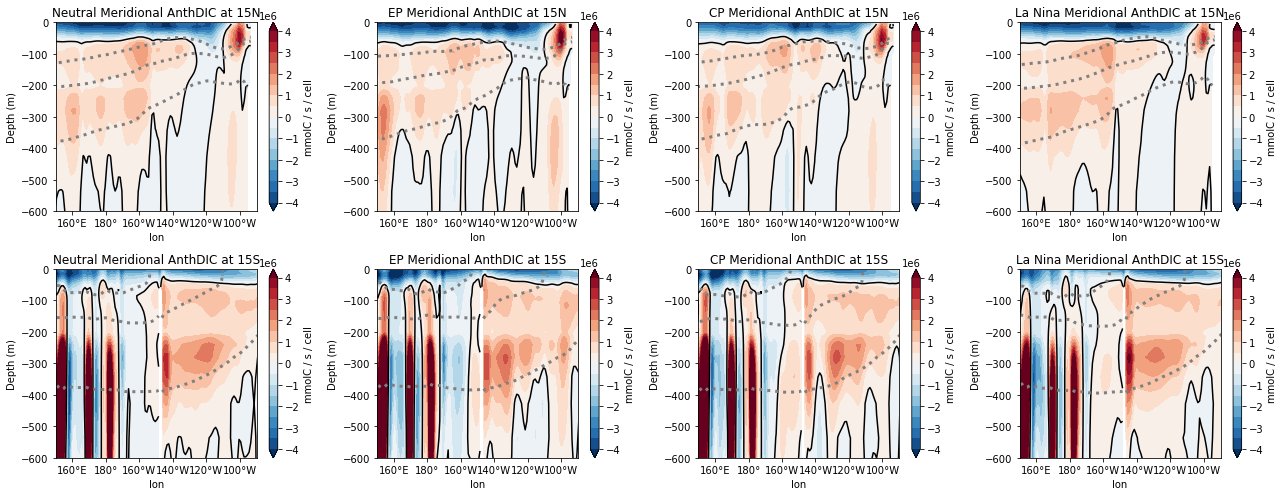

Postive and negative sums [ 24.132645 -29.003242]
Total Sum -4.870595932006836
24631168.0


<timed exec>:47: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 23.481339 -31.556574]
Total Sum -8.075233459472656
24622632.0


<timed exec>:64: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 24.660076 -30.144604]
Total Sum -5.484530448913574
25286698.0


<timed exec>:73: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 23.986015 -31.254307]
Total Sum -7.268290996551514
24340486.0


<timed exec>:86: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 33.34205  -22.539774]
Total Sum 10.802277565002441
38575212.0


<timed exec>:47: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 36.391464 -26.337107]
Total Sum 10.054357528686523
42158620.0


<timed exec>:64: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 35.346764 -23.89762 ]
Total Sum 11.449145317077637
39729144.0


<timed exec>:73: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 32.94203 -21.99424]
Total Sum 10.947790145874023
36346028.0


<timed exec>:86: UserWarning: FixedFormatter should only be used together with FixedLocator


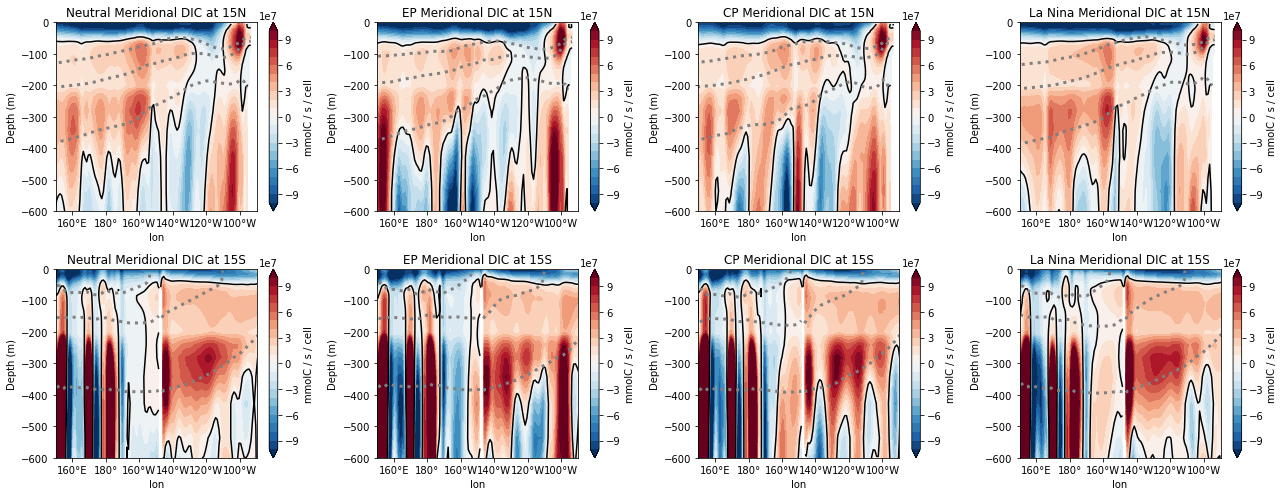

CPU times: user 1min 39s, sys: 20.3 s, total: 1min 59s
Wall time: 16min 52s


surface_sum  upperthermocline_sum  \
Neutral Meridional AnthDIC at 15N    -0.590819              0.087260   
EP Meridional AnthDIC at 15N         -0.659267              0.050760   
CP Meridional AnthDIC at 15N         -0.561817              0.082698   
Nina Meridional AnthDIC at 15N       -0.656544              0.097862   
Neutral Meridional AnthDIC at 15S    -0.270817             -0.004606   
EP Meridional AnthDIC at 15S         -0.320462             -0.019587   
CP Meridional AnthDIC at 15S         -0.291065              0.004558   
Nina Meridional AnthDIC at 15S       -0.210650             -0.020789   
Neutral Meridional DIC at 15N       -17.359493              2.784555   
EP Meridional DIC at 15N            -18.416573              1.704331   
CP Meridional DIC at 15N            -17.421953              2.579227   
Nina Meridional DIC at 15N          -19.942125              3.067122   
Neutral Meridional DIC at 15S        -8.095361             -0.285300   
EP Meridional DIC at 15S             -8.971585             -0.639341   
CP Meridional DIC at 15S             -8.569355              0.013390   
Nina Meridional DIC at 15S           -6.453819             -0.753239   

                                   lowerthermocline_sum  thermostad_sum  \
Neutral Meridional AnthDIC at 15N              0.182391        0.037891   
EP Meridional AnthDIC at 15N                   0.184241        0.039693   
CP Meridional AnthDIC at 15N                   0.172186        0.032851   
Nina Meridional AnthDIC at 15N                 0.182168        0.031775   
Neutral Meridional AnthDIC at 15S              0.374797        0.087563   
EP Meridional AnthDIC at 15S                   0.378091        0.087618   
CP Meridional AnthDIC at 15S                   0.374792        0.094762   
Nina Meridional AnthDIC at 15S                 0.357310        0.082973   
Neutral Meridional DIC at 15N                  7.169894        2.534450   
EP Meridional DIC at 15N                       6.888300        1.748706   
CP Meridional DIC at 15N                       6.841485        2.516710   
Nina Meridional DIC at 15N                     7.395141        2.211573   
Neutral Meridional DIC at 15S                 13.526086        5.656853   
EP Meridional DIC at 15S                      13.236964        6.428321   
CP Meridional DIC at 15S                      13.795649        6.209463   
Nina Meridional DIC at 15S                    13.379453        4.775397   

                                   Total Sum  Total Sum 100m  Positive Sum  \
Neutral Meridional AnthDIC at 15N  -0.283277       -0.623819      0.616030   
EP Meridional AnthDIC at 15N       -0.384573       -0.718743      0.589907   
CP Meridional AnthDIC at 15N       -0.274082       -0.591785      0.587029   
Nina Meridional AnthDIC at 15N     -0.344739       -0.691915      0.600893   
Neutral Meridional AnthDIC at 15S   0.186937       -0.313818      0.790323   
EP Meridional AnthDIC at 15S        0.125660       -0.380489      0.867698   
CP Meridional AnthDIC at 15S        0.183047       -0.328357      0.813486   
Nina Meridional AnthDIC at 15S      0.208844       -0.261119      0.756298   
Neutral Meridional DIC at 15N      -4.870596      -18.141109     24.132645   
EP Meridional DIC at 15N           -8.075233      -19.894093     23.481339   
CP Meridional DIC at 15N           -5.484530      -18.164526     24.660076   
Nina Meridional DIC at 15N         -7.268291      -20.897326     23.986015   
Neutral Meridional DIC at 15S      10.802278       -9.779501     33.342049   
EP Meridional DIC at 15S           10.054358      -10.990927     36.391464   
CP Meridional DIC at 15S           11.449145       -9.967028     35.346764   
Nina Meridional DIC at 15S         10.947790       -8.205550     32.942032   

                                   Negative Sum  
Neutral Meridional AnthDIC at 15N     -0.899307  
EP Meridional AnthDIC at 15N          -0.974480  
CP Meridional AnthDIC at 15N          -0.861110  
Nina Me

In [30]:
%%time
longitude_labels=['','160°E','180°','160°W','140°W','120°W','100°W']
densitylevs=[1023,1024.5,1026.3]#,1026.7,1027,1027.5]
ylim=-600

plot=True
if plot==True:
    N_S_data_holder=[anth_dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)),
                     dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700))]
                     #((grid_multiplier_lon*(anth_dic_tx_v_OLD.chunk('auto').sel(st_ocean=slice(0,-500)))/1000000).T)]

    N_S_names=['Meridional AnthDIC','Meridional DIC']#,'Old Attempt']


    for i, N_S_data in enumerate(N_S_data_holder):
        plt.figure(figsize=(18,7))

        for xi,lat in enumerate([15,-15]):
            #Client.restart()
            #time.sleep(10)
            adic_tx_n=N_S_data.sel(lat=lat,method='nearest')#(grid_multiplier_lon*(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-500)))).T
            if lat==15: 
                direct='15N'
                adic_tx_n=adic_tx_n*-1  # Calculate Transport OUT of the box
            if lat==-15: direct='15S'

            
            
            if ((i==0)|(i==2)): 
                levs=np.arange(-4e6,4.5e6,5e5)
            elif i==1: 
                levs=np.arange(-1e8,1.1e8,1e7)
            #else: levs=np.arange(-10,10,1)
            contour=[0]#60,-60]
            
         

            subpl=plt.subplot(2,4,1+(xi*4))        
            ax=adic_tx_n.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_n.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_neutral=xarray_posneg_calc(adic_tx_n,enso_months=neutral_events,lat=lat)
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            asum_neutral.index=[f'Neutral {N_S_names[i]} at {direct}']
            #print(asum)
            plt.title(f'Neutral {N_S_names[i]} at {direct}')
            plt.xlim([150,270])
            plt.ylim([ylim,0])
            subpl.set_xticklabels(longitude_labels)
            plt.ylabel('Depth (m)')
            
            #cbar=plt.colorbar(ax)
            #cbar.set_label()#, rotation=270)

            subpl=plt.subplot(2,4,2+(xi*4))
            adic_tx_n.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_n.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_ep=xarray_posneg_calc(adic_tx_n,enso_months=ep_events,lat=lat)
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            asum_ep.index=[f'EP {N_S_names[i]} at {direct}']
            #print(asum)
            plt.title(f'EP {N_S_names[i]} at {direct}')
            plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.ylabel('Depth (m)')
            subpl.set_xticklabels(longitude_labels)

            subpl=plt.subplot(2,4,3+(xi*4))
            adic_tx_n.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_n.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_cp=xarray_posneg_calc(adic_tx_n,enso_months=cp_events,lat=lat)
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            asum_cp.index=[f'CP {N_S_names[i]} at {direct}']
            plt.title(f'CP {N_S_names[i]} at {direct}')
            subpl.set_xticklabels(longitude_labels)
            plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.ylabel('Depth (m)')
            
            subpl=plt.subplot(2,4,4+(xi*4))
            adic_tx_n.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_n.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_nina=xarray_posneg_calc(adic_tx_n,enso_months=nina_events,lat=lat)
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            asum_nina.index=[f'Nina {N_S_names[i]} at {direct}']
            plt.title(f'La Nina {N_S_names[i]} at {direct}')
            plt.xlim([150,270])
            subpl.set_xticklabels(longitude_labels)
            plt.ylim([ylim,0])
            plt.ylabel('Depth (m)')
            
            temp_holder=pd.concat([asum_neutral,asum_ep,asum_cp,asum_nina])#,index=[f'{N_S_names[i]} in {direct}',f'{N_S_names[i]} out {direct}'])
            dic_transport_through_box=dic_transport_through_box.append(temp_holder)
        plt.tight_layout()
        plt.show()
        
dic_transport_through_box                                     

In [31]:
asum_neutral#.index=['hi']

surface_sum  upperthermocline_sum  \
Neutral Meridional DIC at 15S    -8.095361               -0.2853   

                               lowerthermocline_sum  thermostad_sum  \
Neutral Meridional DIC at 15S             13.526086        5.656853   

                               Total Sum  Total Sum 100m  Positive Sum  \
Neutral Meridional DIC at 15S  10.802278       -9.779501     33.342049   

                               Negative Sum  
Neutral Meridional DIC at 15S    -22.539774

In [32]:
use_dask=True

if use_dask==True:
    # Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
    
    #cluster = SLURMCluster(cores=2,processes=1,memory="16GB")
    cluster = SLURMCluster(cores=8,processes=2,memory="47GB")#47GB")
    #cluster = SLURMCluster(cores=8,processes=4,memory="22GB")#47GB")
    
    client = Client(cluster)
    cluster.scale(cores=32)
    #cluster.adapt(minimum=2, maximum=16)
    cluster
    #client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44389 instead
  warnings.warn(


In [33]:
time.sleep(20)

In [34]:
cluster

In [35]:
anth_dic_u_tx

<xarray.DataArray '__xarray_dataarray_variable__' (time: 731, st_ocean: 30, lat: 140, lon: 170)>
dask.array<rechunk-merge, shape=(731, 30, 140, 170), dtype=float32, chunksize=(103, 15, 35, 85), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5

### Plot 3+4: Western and Eastern Faces

Postive and negative sums [ 0.8965156 -1.343698 ]
Total Sum -0.44718247652053833
2830378.5


<timed exec>:52: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.96021056 -1.4351108 ]
Total Sum -0.4749002456665039
2573367.0


<timed exec>:69: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.86574703 -1.4073615 ]
Total Sum -0.5416144728660583
2614538.8


<timed exec>:82: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.8812109 -1.3817062]
Total Sum -0.500495195388794
2874795.5


<timed exec>:95: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.6942037  -0.37575498]
Total Sum 0.31844866275787354
1284608.5


<timed exec>:52: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.82917154 -0.37010062]
Total Sum 0.45907092094421387
1427408.1


<timed exec>:69: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.7578262  -0.38353786]
Total Sum 0.3742883801460266
1433459.2


<timed exec>:82: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.60749406 -0.40672606]
Total Sum 0.20076799392700195
1233891.2


<timed exec>:95: UserWarning: FixedFormatter should only be used together with FixedLocator


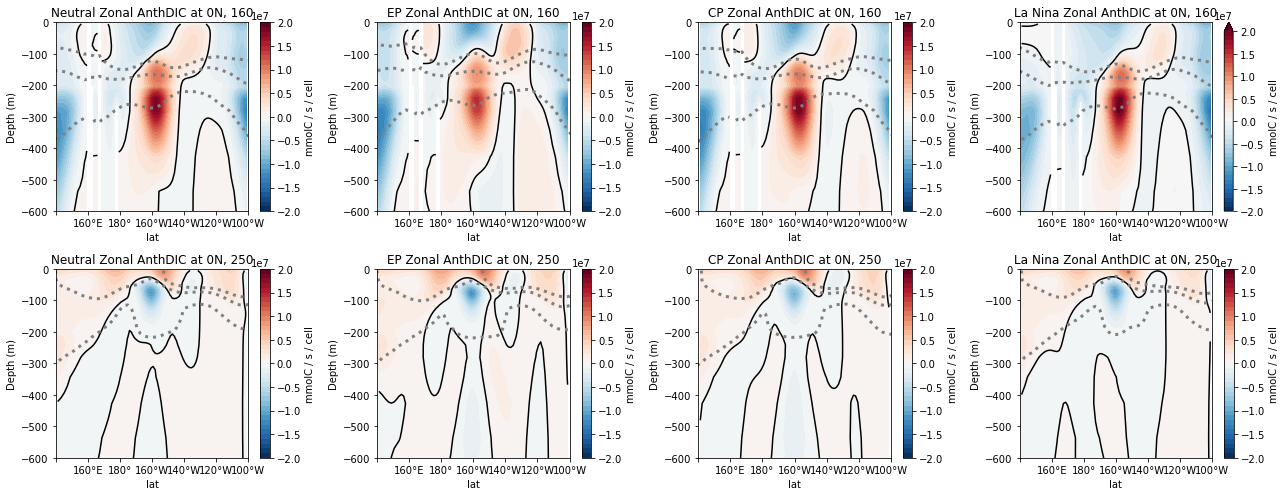

Postive and negative sums [ 41.018993 -50.72582 ]
Total Sum -9.706827163696289
131384210.0


<timed exec>:52: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 42.654587 -51.85383 ]
Total Sum -9.199237823486328
114546770.0


<timed exec>:69: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 40.526707 -53.57313 ]
Total Sum -13.04642105102539
123661800.0


<timed exec>:82: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 42.953682 -53.20078 ]
Total Sum -10.24709701538086
139611760.0


<timed exec>:95: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 30.111172 -20.921856]
Total Sum 9.189316749572754
55759116.0


<timed exec>:52: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 35.759956 -20.953537]
Total Sum 14.806421279907227
61721140.0


<timed exec>:69: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 33.110123 -23.397873]
Total Sum 9.712250709533691
62228256.0


<timed exec>:82: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 25.723026 -24.983671]
Total Sum 0.7393543720245361
53521770.0


<timed exec>:95: UserWarning: FixedFormatter should only be used together with FixedLocator


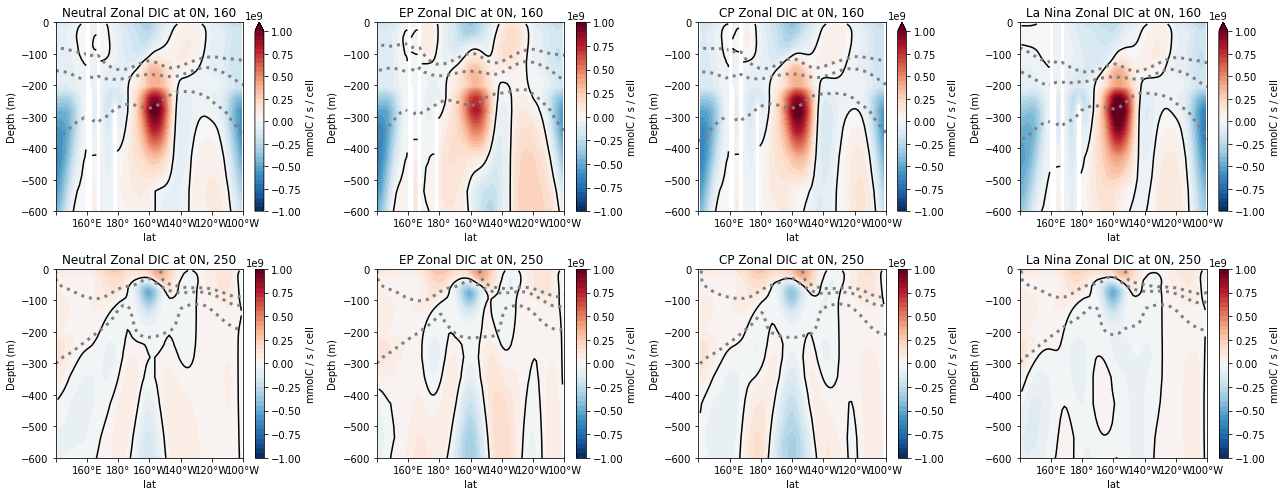

CPU times: user 3min 17s, sys: 40.8 s, total: 3min 58s
Wall time: 29min 36s


In [36]:
%%time

plot=True
if plot==True:

    #anth DIC
    E_W_data_holder=[anth_dic_u_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)),
                     dic_u_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700))]
                     #((grid_multiplier_lat*(anth_dic_tx_u_OLD.chunk('auto').sel(st_ocean=slice(0,-500)))/1000000).T*-1)] # Wrong Direction

    E_W_names=['Zonal AnthDIC','Zonal DIC']#,'Zonal Old Attempt']


    for i, E_W_data in enumerate(E_W_data_holder):
        #Client.restart()
        #time.sleep(10)
        ylim=-600
        plt.figure(figsize=(18,7))
        lons=[160,250]
        for xi, lon in enumerate(lons):
            if i==0 or i==2:
                levs=np.arange(-2e7,2.1e7,1e6)#None#np.arange(-20,22,2)
            elif i==1:# or i==3:
                levs=np.arange(-1e9,1.05e9,5e7)#None#np.arange(-1000,1100,100)
                
                
            #elif i<=4:  
            #levs=None#np.arange(-1e7,1e7,1e6)
            contour=[0]#60,-60]
            
            #lon=180
            lslice=slice(-15,15)#-3,3)

            
            #plt.subplot(251)
            subpl=plt.subplot(2,4,1+(xi*4))

            adic_tx_b=E_W_data.sel(lon=lon,method='nearest').sel(lat=lslice)#.T#grid_multiplier_lat.T*anth_dic_tx_u.sel(lon=lon,method='nearest')#.mean(dim='time')
            if lon==250:
                adic_tx_b*=-1 # Calculate Transport OUT of box. 

            #print(adic_tx_b)
            #(grid_multiplier_lon*(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-500)))).T

            adic_tx_b.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_b.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_neutral=xarray_posneg_calc(adic_tx_b,enso_months=neutral_events,lon=lon)
            asum_neutral.index=[f'Neutral {E_W_names[i]} at {lon}']
            (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            #print(asum)
            plt.title(f'Neutral {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            plt.ylim([ylim,0])
            subpl.set_xticklabels(longitude_labels)
            
            plt.ylabel('Depth (m)')
            plt.xlim([-15,15])

            subpl=plt.subplot(2,4,2+(xi*4))
            adic_tx_b.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_b.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_ep=xarray_posneg_calc(adic_tx_b,enso_months=ep_events,lon=lon)
            asum_ep.index=[f'EP {E_W_names[i]} at {lon}']
            (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            #print(asum)
            plt.title(f'EP {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.ylabel('Depth (m)')
            plt.xlim([-15,15])
            subpl.set_xticklabels(longitude_labels)
               
            subpl=plt.subplot(2,4,3+(xi*4))
            adic_tx_b.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_b.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_cp=xarray_posneg_calc(adic_tx_b,enso_months=cp_events,lon=lon)
            asum_cp.index=[f'CP {E_W_names[i]} at {lon}']
            (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            plt.title(f'CP {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.xlim([-15,15])
            plt.ylabel('Depth (m)')
            subpl.set_xticklabels(longitude_labels)

            subpl=plt.subplot(2,4,4+(xi*4))
            adic_tx_b.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_b.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_nina=xarray_posneg_calc(adic_tx_b,enso_months=nina_events,lon=lon)
            (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            plt.title(f'La Nina {E_W_names[i]} at 0N, {lon}')
            asum_nina.index=[f'Nina {E_W_names[i]} at {lon}']
            #plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.xlim([-15,15])
            plt.ylabel('Depth (m)')
            subpl.set_xticklabels(longitude_labels)

            # Mmol DIC/m2/s
            #cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))
            
            temp_holder=pd.concat([asum_neutral,asum_ep,asum_cp,asum_nina])#,index=[f'{N_S_names[i]} in {direct}',f'{N_S_names[i]} out {direct}'])
            dic_transport_through_box=dic_transport_through_box.append(temp_holder)
            
        plt.tight_layout()
        plt.show()
            #temp_holder

In [37]:
dic_transport_through_box

surface_sum  upperthermocline_sum  \
Neutral Meridional AnthDIC at 15N    -0.590819              0.087260   
EP Meridional AnthDIC at 15N         -0.659267              0.050760   
CP Meridional AnthDIC at 15N         -0.561817              0.082698   
Nina Meridional AnthDIC at 15N       -0.656544              0.097862   
Neutral Meridional AnthDIC at 15S    -0.270817             -0.004606   
EP Meridional AnthDIC at 15S         -0.320462             -0.019587   
CP Meridional AnthDIC at 15S         -0.291065              0.004558   
Nina Meridional AnthDIC at 15S       -0.210650             -0.020789   
Neutral Meridional DIC at 15N       -17.359493              2.784555   
EP Meridional DIC at 15N            -18.416573              1.704331   
CP Meridional DIC at 15N            -17.421953              2.579227   
Nina Meridional DIC at 15N          -19.942125              3.067122   
Neutral Meridional DIC at 15S        -8.095361             -0.285300   
EP Meridional DIC at 15S             -8.971585             -0.639341   
CP Meridional DIC at 15S             -8.569355              0.013390   
Nina Meridional DIC at 15S           -6.453819             -0.753239   
Neutral Zonal AnthDIC at 160         -0.515785             -0.018351   
EP Zonal AnthDIC at 160              -0.511898             -0.039152   
CP Zonal AnthDIC at 160              -0.636524             -0.046206   
Nina Zonal AnthDIC at 160            -0.565702             -0.054746   
Neutral Zonal AnthDIC at 250          0.152702              0.309472   
EP Zonal AnthDIC at 250               0.186040              0.358639   
CP Zonal AnthDIC at 250               0.154411              0.348988   
Nina Zonal AnthDIC at 250             0.116151              0.288935   
Neutral Zonal DIC at 160            -16.951839             -0.171937   
EP Zonal DIC at 160                 -15.765037             -0.908135   
CP Zonal DIC at 160                 -21.100107             -1.189360   
Nina Zonal DIC at 160               -18.396797             -1.433959   
Neutral Zonal DIC at 250              5.574556             12.344210   
EP Zonal DIC at 250                   6.275164             13.253804   
CP Zonal DIC at 250                   5.866344             13.673750   
Nina Zonal DIC at 250                 4.436914             11.504083   

                                   lowerthermocline_sum  thermostad_sum  \
Neutral Meridional AnthDIC at 15N              0.182391        0.037891   
EP Meridional AnthDIC at 15N                   0.184241        0.039693   
CP Meridional AnthDIC at 15N                   0.172186        0.032851   
Nina Meridional AnthDIC at 15N                 0.182168        0.031775   
Neutral Meridional AnthDIC at 15S              0.374797        0.087563   
EP Meridional AnthDIC at 15S                   0.378091        0.087618   
CP Meridional AnthDIC at 15S                   0.374792        0.094762   
Nina Meridional AnthDIC at 15S                 0.357310        0.082973   
Neutral Meridional DIC at 15N                  7.169894        2.534450   
EP Meridional DIC at 15N                       6.888300        1.748706   
CP Meridional DIC at 15N                       6.841485        2.516710   
Nina Meridional DIC at 15N                     7.395141        2.211573   
Neutral Meridional DIC at 15S                 13.526086        5.656853   
EP Meridional DIC at 15S                      13.236964        6.428321   
CP Meridional DIC at 15S                      13.795649        6.209463   
Nina Meridional DIC at 15S                    13.379453        4.775397   
Neutral Zonal AnthDIC at 160                  -0.005094        0.092048   
EP Zonal AnthDIC at 160                        0.002127        0.074023   
CP Zonal AnthDIC at 160                        0.039844        0.101272   
Nina Zonal AnthDIC at 160                      0.013132        0.106820   
Neutral Zonal AnthDIC at 250                  -0.141203       -0.002522   
EP Zonal

In [38]:
use_dask=True

if use_dask==True:
    # Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
    
    #cluster = SLURMCluster(cores=2,processes=1,memory="16GB")
    cluster = SLURMCluster(cores=8,processes=2,memory="47GB")#47GB")
    #cluster = SLURMCluster(cores=8,processes=4,memory="22GB")#47GB")
    
    client = Client(cluster)
    cluster.scale(cores=32)
    #cluster.adapt(minimum=2, maximum=16)
    cluster
    #client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36711 instead
  warnings.warn(


In [39]:
time.sleep(20)


### Plot 5+6: Upwelling and Outgassing (Vertical Top and Bottom Faces)
upwelling
anthupwelling

flux
anthflux


In [40]:
cluster

In [41]:
%%time
save_new_upwelling_density=False
if save_new_upwelling_density==True:
    upwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').interp(st_ocean=cafe_wt.rename({'sw_ocean':'st_ocean'}).st_ocean).rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups (From m3?)
    anthupwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').interp(st_ocean=cafe_wt.rename({'sw_ocean':'st_ocean'}).st_ocean).rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups


    upwelling=upwelling.interp(st_ocean=cafe_potential_density.st_ocean)
    anthupwelling=anthupwelling.interp(st_ocean=cafe_potential_density.st_ocean)


    surface_to_upperthermocline=upwelling.where((density_timefix.chunk('auto')>=1022.7)&(density_timefix.chunk('auto')<=1023.3)).mean(dim='st_ocean') #Average across a few pixels
    upper_to_lowerthermocline=upwelling.where((density_timefix.chunk('auto')>=1024.3)&(density_timefix.chunk('auto')<=1024.7)).mean(dim='st_ocean')
    lowerthermocline_to_thermostad=upwelling.where((density_timefix.chunk('auto')>=1026.1)&(density_timefix.chunk('auto')<=1026.5)).mean(dim='st_ocean')

    anth_surface_to_upperthermocline=anthupwelling.where((density_timefix.chunk('auto')>=1022.7)&(density_timefix.chunk('auto')<=1023.3)).mean(dim='st_ocean') #Average across a few pixels
    anth_upper_to_lowerthermocline=anthupwelling.where((density_timefix.chunk('auto')>=1024.3)&(density_timefix.chunk('auto')<=1024.7)).mean(dim='st_ocean')
    anth_lowerthermocline_to_thermostad=anthupwelling.where((density_timefix.chunk('auto')>=1026.1)&(density_timefix.chunk('auto')<=1026.5)).mean(dim='st_ocean')

    print('saving')
    surface_to_upperthermocline.to_netcdf('../processed_data/upwelling_through_layers/surface_to_upperthermocline.nc')
    print('saving')
    upper_to_lowerthermocline.to_netcdf('../processed_data/upwelling_through_layers/upper_to_lowerthermocline.nc')
    print('saving')
    lowerthermocline_to_thermostad.to_netcdf('../processed_data/upwelling_through_layers/lowerthermocline_to_thermostad.nc')
    print('saving')
    anth_surface_to_upperthermocline.to_netcdf('../processed_data/upwelling_through_layers/anth_surface_to_upperthermocline.nc')
    print('saving')
    anth_upper_to_lowerthermocline.to_netcdf('../processed_data/upwelling_through_layers/anth_upper_to_lowerthermocline.nc')
    print('saving')
    anth_lowerthermocline_to_thermostad.to_netcdf('../processed_data/upwelling_through_layers/anth_lowerthermocline_to_thermostad.nc')

surface_to_upperthermocline=xr.open_dataset('../processed_data/upwelling_through_layers/surface_to_upperthermocline.nc').__xarray_dataarray_variable__
upper_to_lowerthermocline=xr.open_dataset('../processed_data/upwelling_through_layers/upper_to_lowerthermocline.nc').__xarray_dataarray_variable__
lowerthermocline_to_thermostad=xr.open_dataset('../processed_data/upwelling_through_layers/lowerthermocline_to_thermostad.nc').__xarray_dataarray_variable__

anth_surface_to_upperthermocline=xr.open_dataset('../processed_data/upwelling_through_layers/anth_surface_to_upperthermocline.nc').__xarray_dataarray_variable__
anth_upper_to_lowerthermocline=xr.open_dataset('../processed_data/upwelling_through_layers/anth_upper_to_lowerthermocline.nc').__xarray_dataarray_variable__
anth_lowerthermocline_to_thermostad=xr.open_dataset('../processed_data/upwelling_through_layers/anth_lowerthermocline_to_thermostad.nc').__xarray_dataarray_variable__


#Dens Calcs for upwelling
#dic_u_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_u_tx_density.nc').tracer.chunk('auto')#*1e6#.__xarray_dataarray_variable__
#anth_dic_u_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_u_tx_density.nc').tracer.chunk('auto')#*1e6#.__xarray_dataarray_variable__

#dic_v_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_v_tx_density.nc').tracer.chunk('auto')#*1e6#.__xarray_dataarray_variable__
#anth_dic_v_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_v_tx_density.nc').tracer.chunk('auto')#*1e6#.__xarray_dataarray_variable__
dic_w_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/upwelling_density.nc').tracer#.__xarray_dataarray_variable__
anth_dic_w_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anthupwelling_density.nc').tracer



#dic_w_tx_dens.sel(density=25,method='nearest').mean(dim='time').plot()


CPU times: user 107 ms, sys: 29 ms, total: 136 ms
Wall time: 212 ms


Postive and negative sums [ 53.54876369 -22.54294367]
Total Sum 31.0058200196296
29991877.872049846
Postive and negative sums [ 56.30569865 -22.82358026]
Total Sum 33.48211839208354
30614574.620151028
Postive and negative sums [ 58.71614376 -25.31893015]
Total Sum 33.39721361352276
32170099.950794086
Postive and negative sums [ 57.24457017 -24.51108868]
Total Sum 32.73348149724366
30732991.541634675


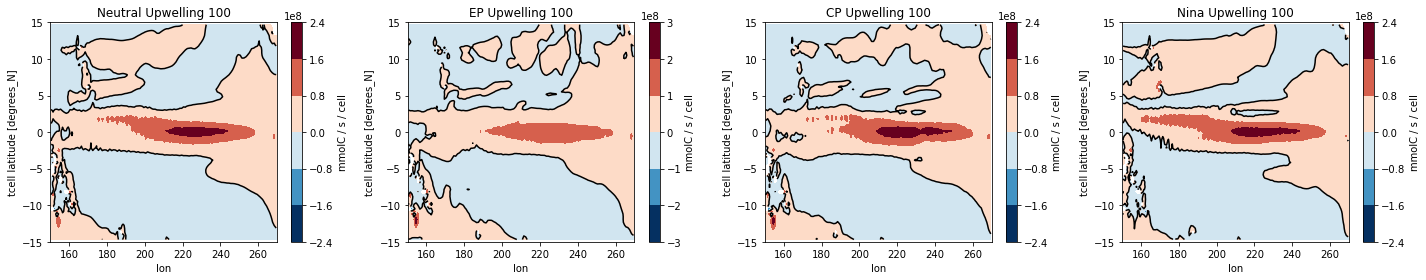

Postive and negative sums [ 1.32813681 -0.65827902]
Total Sum 0.6698577902397422
745766.7882117794
Postive and negative sums [ 1.4759708  -0.71386062]
Total Sum 0.7621101793451072
827195.5981349179
Postive and negative sums [ 1.47860685 -0.76684113]
Total Sum 0.7117657187812223
803288.0284787221
Postive and negative sums [ 1.39615573 -0.69678722]
Total Sum 0.6993685028654278
748947.8897949876


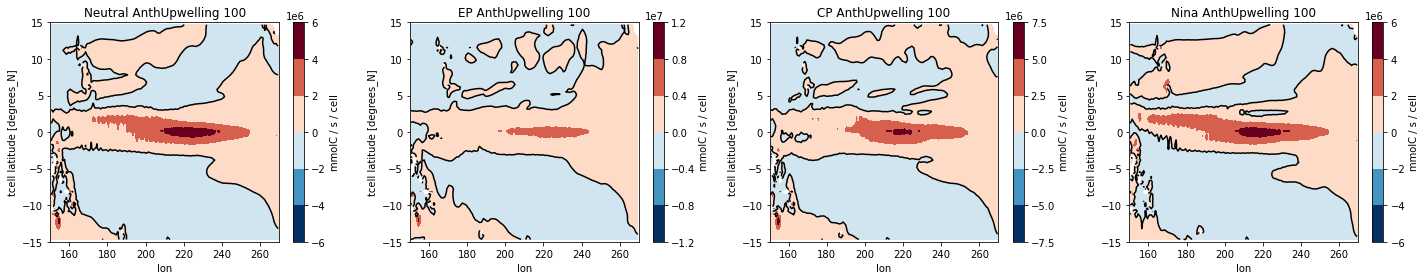

Postive and negative sums [15.22839335 -8.86864552]
Total Sum 6.359747824915312
6864681.9252645215
Postive and negative sums [ 22.58973779 -12.42653533]
Total Sum 10.163202462909513
10726503.239716273
Postive and negative sums [ 19.70260747 -11.61222036]
Total Sum 8.090387117748717
8957983.260451429
Postive and negative sums [16.38906924 -6.73304924]
Total Sum 9.656019997688745
6397020.882263935


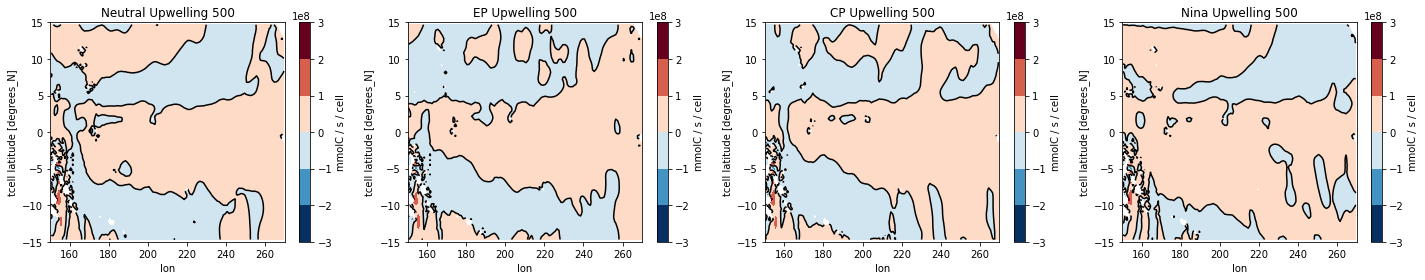

Postive and negative sums [ 0.10699751 -0.08025803]
Total Sum 0.02673948519142421
48984.593713261034
Postive and negative sums [ 0.14685327 -0.11175199]
Total Sum 0.03510127506731805
72358.23555762417
Postive and negative sums [ 0.14874409 -0.09976247]
Total Sum 0.04898161600269406
66574.1315634998
Postive and negative sums [ 0.11902649 -0.06119927]
Total Sum 0.057827220278910886
48166.22304422076


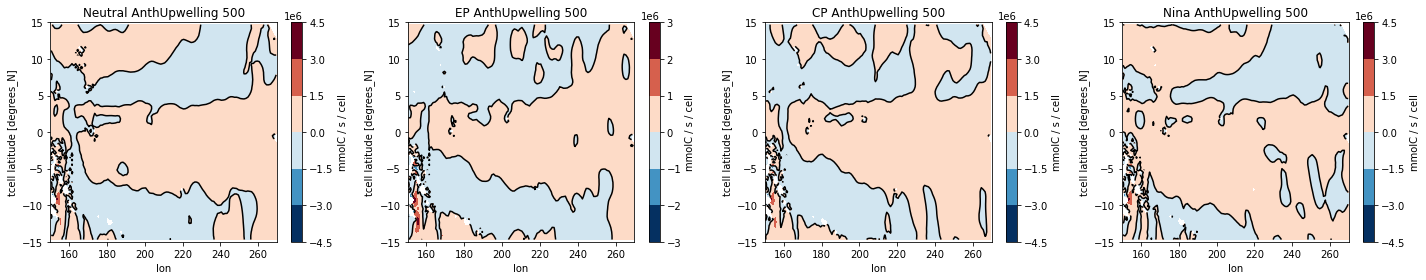

Postive and negative sums [ 36.42830451 -20.26456224]
Total Sum 16.163742273819043
23234651.990695246
Postive and negative sums [ 43.3737379  -20.13809512]
Total Sum 23.235642776667977
25790807.94767898
Postive and negative sums [ 43.81570087 -23.60525841]
Total Sum 20.21044245819723
27026664.335310433
Postive and negative sums [ 40.07269307 -20.95522192]
Total Sum 19.11747115339645
24950847.499985658


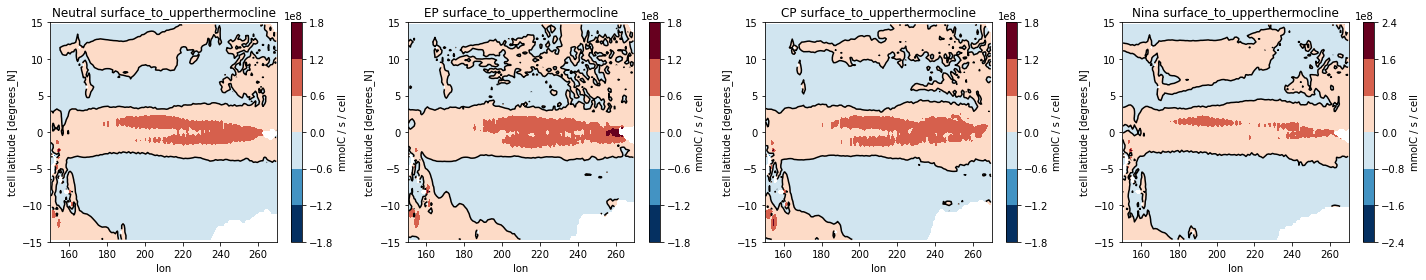

Postive and negative sums [ 51.91117502 -17.21098346]
Total Sum 34.700191560675556
28589908.320436783
Postive and negative sums [ 58.31262267 -19.71812028]
Total Sum 38.59450238668387
30591640.773598902
Postive and negative sums [ 58.28143933 -21.84765827]
Total Sum 36.43378105855185
32753656.55801962
Postive and negative sums [ 55.19774901 -15.69570528]
Total Sum 39.50204373259026
29247863.43144211


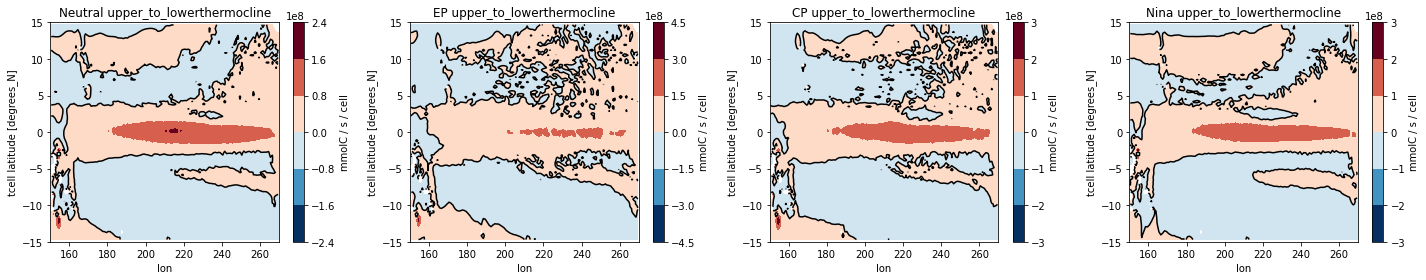

Postive and negative sums [35.00556876 -8.6916094 ]
Total Sum 26.313959365974448
15149297.190923061
Postive and negative sums [ 37.54435651 -10.80004892]
Total Sum 26.744307582645707
16433710.65900494
Postive and negative sums [ 40.60618991 -11.61638554]
Total Sum 28.98980436610864
17376704.929883346
Postive and negative sums [37.52928559 -6.4282985 ]
Total Sum 31.100987088142634
13762210.186752087


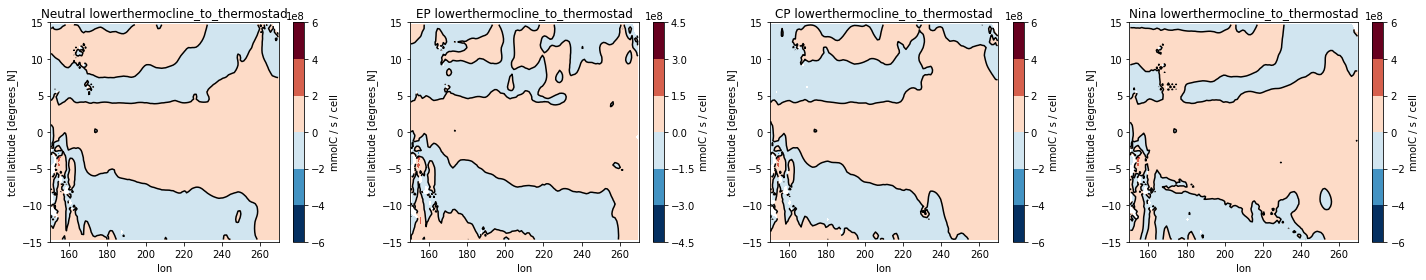

Postive and negative sums [ 0.98968635 -0.58574546]
Total Sum 0.4039408898391577
628358.7292739936
Postive and negative sums [ 1.29002407 -0.62684861]
Total Sum 0.6631754611668382
768454.9692404538
Postive and negative sums [ 1.1844655  -0.69867931]
Total Sum 0.4857861912717451
713780.9685925185
Postive and negative sums [ 1.03306835 -0.59275092]
Total Sum 0.4403174255571903
637669.985451681


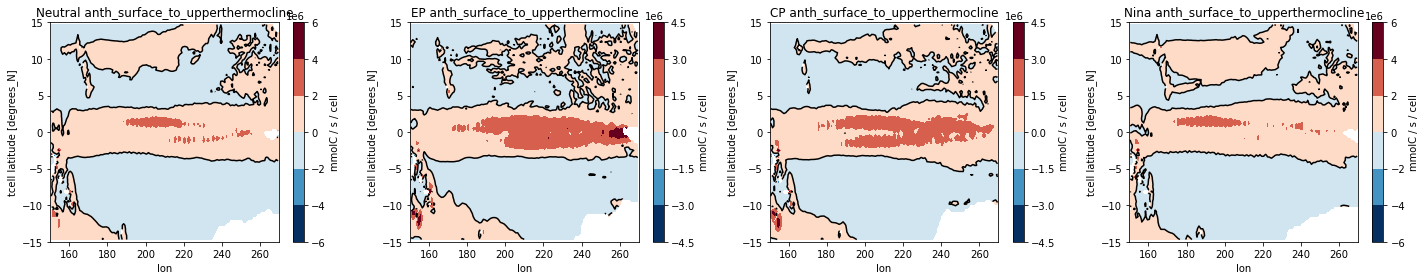

Postive and negative sums [ 1.34597165 -0.48873638]
Total Sum 0.8572352721372416
737446.9742147037
Postive and negative sums [ 1.59996493 -0.59887906]
Total Sum 1.0010858701282148
835714.4877549963
Postive and negative sums [ 1.51090024 -0.63757869]
Total Sum 0.8733215559377544
847490.4902903058
Postive and negative sums [ 1.38465528 -0.44931522]
Total Sum 0.9353400572203515
743080.3368563706


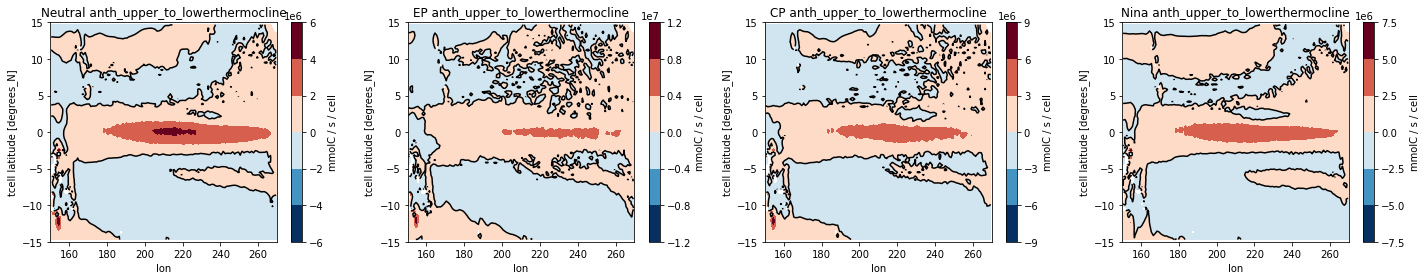

Postive and negative sums [ 0.57936778 -0.15161061]
Total Sum 0.4277571687174985
250526.80695744487
Postive and negative sums [ 0.63500303 -0.19301398]
Total Sum 0.44198905144828704
276712.4824723125
Postive and negative sums [ 0.68866136 -0.20389165]
Total Sum 0.48476970972271094
291677.4634494207
Postive and negative sums [ 0.60828206 -0.11912724]
Total Sum 0.4891548252354762
230812.0059235816


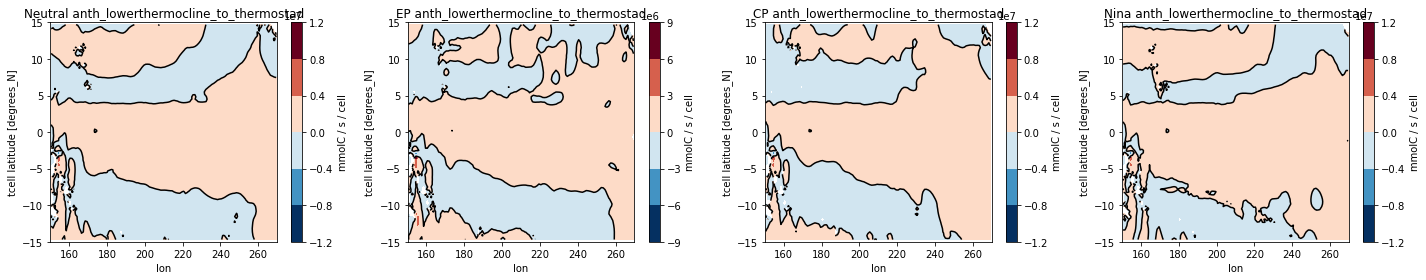

Postive and negative sums [ 0.05961746 -0.48404518]
Total Sum -0.42442771792411804
76142.15
Postive and negative sums [ 0.1179653  -0.39117453]
Total Sum -0.27320921421051025
106571.37
Postive and negative sums [ 0.0748643  -0.49797508]
Total Sum -0.42311081290245056
88237.12
Postive and negative sums [ 0.06363034 -0.49440244]
Total Sum -0.430772066116333
80450.76


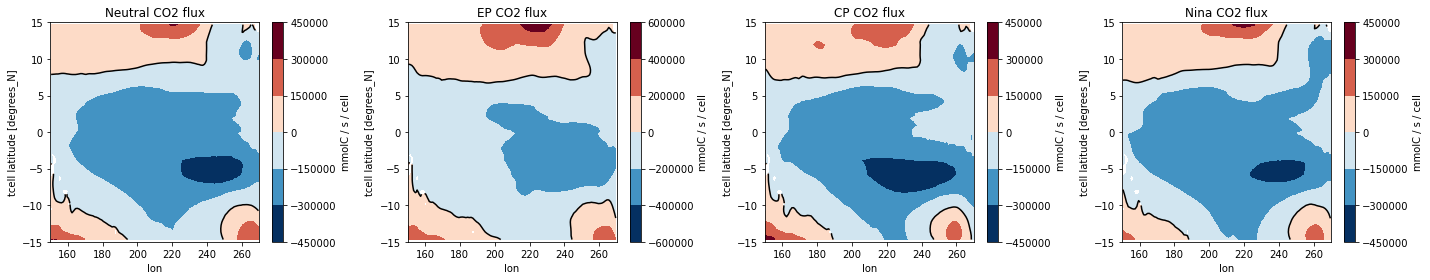

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


Postive and negative sums [0.30264318 0.        ]
Total Sum 0.30264317989349365
79503.85
Postive and negative sums [0.3453856 0.       ]
Total Sum 0.3453856110572815
90732.23


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


Postive and negative sums [0.29159427 0.        ]
Total Sum 0.2915942668914795
76601.33
Postive and negative sums [0.29965293 0.        ]
Total Sum 0.29965293407440186
78718.32


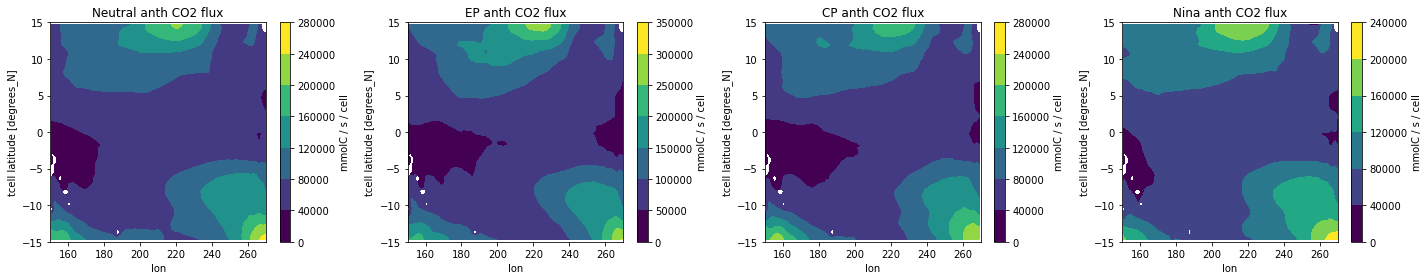

In [42]:
plot=True

if plot==True:
    density_timefix=cafe_potential_density#.sel(time=enso_months).mean(dim='time')
    #Density FIxed Upwelling??
    contour=[0]
    
    #surface_to_upperthermocline=upwelling.where((density_timefix.chunk('auto')>=1022.8)&(density_timefix.chunk('auto')<=1023.2)).mean(dim='st_ocean') #Average across a few pixels
    #upper_to_lowerthermocline=upwelling.where((density_timefix.chunk('auto')>=1024.3)&(density_timefix.chunk('auto')<=1024.7)).mean(dim='st_ocean')
    #lowerthermocline_to_thermostad=upwelling.where((density_timefix.chunk('auto')>=1026.1)&(density_timefix.chunk('auto')<=1026.5)).mean(dim='st_ocean')

    #anth_surface_to_upperthermocline=anthupwelling.where((density_timefix.chunk('auto')>=1022.8)&(density_timefix.chunk('auto')<=1023.2)).mean(dim='st_ocean') #Average across a few pixels
    #anth_upper_to_lowerthermocline=anthupwelling.where((density_timefix.chunk('auto')>=1024.3)&(density_timefix.chunk('auto')<=1024.7)).mean(dim='st_ocean')
    #anth_lowerthermocline_to_thermostad=anthupwelling.where((density_timefix.chunk('auto')>=1026.1)&(density_timefix.chunk('auto')<=1026.5)).mean(dim='st_ocean')

    
    #anth DIC
    T_B_data_holder=[upwelling_100.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_100.sel(time=slice('2000-01-01','2020-01-01')),
                     upwelling_500.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_500.sel(time=slice('2000-01-01','2020-01-01')),
                     
                     surface_to_upperthermocline.sel(time=slice('2000-01-01','2020-01-01')),
                     upper_to_lowerthermocline.sel(time=slice('2000-01-01','2020-01-01')),
                     lowerthermocline_to_thermostad.sel(time=slice('2000-01-01','2020-01-01')),
                     
                     anth_surface_to_upperthermocline.sel(time=slice('2000-01-01','2020-01-01')),
                     anth_upper_to_lowerthermocline.sel(time=slice('2000-01-01','2020-01-01')),
                     anth_lowerthermocline_to_thermostad.sel(time=slice('2000-01-01','2020-01-01')),
                     
                     flux.sel(time=slice('2000-01-01','2020-01-01'))*-1,
                     anthflux.sel(time=slice('2000-01-01','2020-01-01'))*-1]
                     
                     #dic_w_tx_dens.sel(density=1023,method='nearest'),
                     #anth_dic_w_tx_dens.sel(density=1023,method='nearest'),

                     #dic_w_tx_dens.sel(density=1024.5,method='nearest'),
                     #anth_dic_w_tx_dens.sel(density=1024.5,method='nearest'),

                     #dic_w_tx_dens.sel(density=1026.3, method='nearest'),
                     #anth_dic_w_tx_dens.sel(density=1026.3,method='nearest')]

    #T_B_names=['Upwelling','Anthropogenic Upwelling','Upwelling Old', 'Anth Upwelling Old', 'CO2 flux', 'anth CO2 flux', 'CO2 flux OLD',' anth CO2 flux OLD']
    T_B_names=['Upwelling 100','AnthUpwelling 100','Upwelling 500','AnthUpwelling 500',
               'surface_to_upperthermocline','upper_to_lowerthermocline','lowerthermocline_to_thermostad',
               'anth_surface_to_upperthermocline','anth_upper_to_lowerthermocline','anth_lowerthermocline_to_thermostad',
               'CO2 flux', 'anth CO2 flux']#,'Upwelling 23','Anthropogenic Upwelling 23','Upwelling 24.5','Anthropogenic Upwelling 24.5','Upwelling 26.3','Anthropogenic Upwelling 26.3']


    for i, T_B_data in enumerate(T_B_data_holder):
        if i==0:
            levs=None#np.arange(-40,45,5)
        elif i==1:
            levs=None#np.arange(-2,2.2,0.2)
        
        plt.figure(figsize=(20,4))
        plt.subplot(141)
        lslice=slice(-15,15)
        upwelling_dat=T_B_data.sel(lat=lslice,lon=slice(150,270))

        upwelling_dat.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_neutral=xarray_posneg_calc(upwelling_dat,enso_months=neutral_events,run_density_calc=False)

        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        #print(asum)
        plt.title(f'Neutral {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-15,15])

        plt.subplot(142)
        upwelling_dat.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_ep=xarray_posneg_calc(upwelling_dat,enso_months=ep_events,run_density_calc=False)
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        #print(asum)
        plt.title(f'EP {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-15,15])

        plt.subplot(143)
        upwelling_dat.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_cp=xarray_posneg_calc(upwelling_dat,enso_months=cp_events,run_density_calc=False)
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        plt.title(f'CP {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-15,15])

        plt.subplot(144)
        upwelling_dat.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_nina=xarray_posneg_calc(upwelling_dat,enso_months=nina_events,run_density_calc=False)
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        plt.title(f'Nina {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-15,15])


        plt.tight_layout()
        plt.show()
         
        name_str=''
        if pd.Series(T_B_names[i]).str.contains('_to_').iloc[0] ==True:
            if pd.Series(T_B_names[i]).str.contains('anth').iloc[0] ==True:
                name_str='Anth Upwelling'
            else:
                name_str='Upwelling'
        else:
            name_str=T_B_names[i]
            
        temp_holder=pd.DataFrame({f'Neutral {name_str}':asum_neutral,
                                  f'EP {name_str}':asum_ep,
                                  f'CP {name_str}':asum_cp,
                                  f'Nina {name_str}':asum_nina},index=[f'{T_B_names[i]} in',f'{T_B_names[i]} out']).T #Transpose because i did it backwards
        dic_transport_through_box=dic_transport_through_box.append(temp_holder)

In [43]:
dic_transport_through_box#=dic_transport_through_box[:-8]

surface_sum  upperthermocline_sum  \
Neutral Meridional AnthDIC at 15N    -0.590819              0.087260   
EP Meridional AnthDIC at 15N         -0.659267              0.050760   
CP Meridional AnthDIC at 15N         -0.561817              0.082698   
Nina Meridional AnthDIC at 15N       -0.656544              0.097862   
Neutral Meridional AnthDIC at 15S    -0.270817             -0.004606   
...                                        ...                   ...   
Nina CO2 flux                              NaN                   NaN   
Neutral anth CO2 flux                      NaN                   NaN   
EP anth CO2 flux                           NaN                   NaN   
CP anth CO2 flux                           NaN                   NaN   
Nina anth CO2 flux                         NaN                   NaN   

                                   lowerthermocline_sum  thermostad_sum  \
Neutral Meridional AnthDIC at 15N              0.182391        0.037891   
EP Meridional AnthDIC at 15N                   0.184241        0.039693   
CP Meridional AnthDIC at 15N                   0.172186        0.032851   
Nina Meridional AnthDIC at 15N                 0.182168        0.031775   
Neutral Meridional AnthDIC at 15S              0.374797        0.087563   
...                                                 ...             ...   
Nina CO2 flux                                       NaN             NaN   
Neutral anth CO2 flux                               NaN             NaN   
EP anth CO2 flux                                    NaN             NaN   
CP anth CO2 flux                                    NaN             NaN   
Nina anth CO2 flux                                  NaN             NaN   

                                   Total Sum  Total Sum 100m  Positive Sum  \
Neutral Meridional AnthDIC at 15N  -0.283277       -0.623819      0.616030   
EP Meridional AnthDIC at 15N       -0.384573       -0.718743      0.589907   
CP Meridional AnthDIC at 15N       -0.274082       -0.591785      0.587029   
Nina Meridional AnthDIC at 15N     -0.344739       -0.691915      0.600893   
Neutral Meridional AnthDIC at 15S   0.186937       -0.313818      0.790323   
...                                      ...             ...           ...   
Nina CO2 flux                            NaN             NaN           NaN   
Neutral anth CO2 flux                    NaN             NaN           NaN   
EP anth CO2 flux                         NaN             NaN           NaN   
CP anth CO2 flux                         NaN             NaN           NaN   
Nina anth CO2 flux                       NaN             NaN           NaN   

                                   Negative Sum Upwelling 100 in  \
Neutral Meridional AnthDIC at 15N     -0.899307              NaN   
EP Meridional AnthDIC at 15N          -0.974480              NaN   
CP Meridional AnthDIC at 15N          -0.861110              NaN   
Nina Meridional AnthDIC at 15N        -0.945632              NaN   
Neutral Meridional AnthDIC at 15S     -0.603387              NaN   
...                                         ...              ...   
Nina CO2 flux                               NaN              NaN   
Neutral anth CO2 flux                       NaN              NaN   
EP anth CO2 flux                            NaN              NaN   
CP anth CO2 flux                            NaN              NaN   
Nina anth CO2 flux                          NaN              NaN   

                                  Upwelling 100 out  ...  \
Neutral Meridional AnthDIC at 15N               NaN  ...   
EP Meridional AnthDIC at 15N                    NaN  ...   
CP Meridional AnthDIC at 15N                    NaN  ...   
Nina Meridional AnthDIC at 15N                  NaN  ...   
Neutral Meridional AnthDIC at 15S               NaN  ...   
...                                             ...  ...   
Nina CO2 flux                                   NaN  ...   
Neutral anth CO2 flux              

In [44]:
dic_transport_through_box.to_csv('dic_tx_big.csv')

## End Box Estimate

In [45]:

dic_transport_through_box = pd.read_csv('dic_tx_big.csv',index_col=0)

#dic_transport_through_box
# in PgC/yr???"

In [46]:
# Bit of Data Wrangling

dic_transport_through_box = pd.read_csv('dic_tx_big.csv',index_col=0)

dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(dic_transport_through_box['Upwelling 100 in']+dic_transport_through_box['Upwelling 100 out'])
dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(dic_transport_through_box['AnthUpwelling 100 in']+dic_transport_through_box['AnthUpwelling 100 out'])

dic_transport_through_box['upperthermocline_sum']=dic_transport_through_box['upperthermocline_sum'].fillna(
    dic_transport_through_box['surface_to_upperthermocline in']+dic_transport_through_box['surface_to_upperthermocline out'])
dic_transport_through_box['upperthermocline_sum']=dic_transport_through_box['upperthermocline_sum'].fillna(
    dic_transport_through_box['anth_surface_to_upperthermocline in']+dic_transport_through_box['anth_surface_to_upperthermocline out'])


dic_transport_through_box['lowerthermocline_sum']=dic_transport_through_box['lowerthermocline_sum'].fillna(
    dic_transport_through_box['upper_to_lowerthermocline in']+dic_transport_through_box['upper_to_lowerthermocline out'])
dic_transport_through_box['lowerthermocline_sum']=dic_transport_through_box['lowerthermocline_sum'].fillna(
    dic_transport_through_box['anth_upper_to_lowerthermocline in']+dic_transport_through_box['anth_upper_to_lowerthermocline out'])

dic_transport_through_box['thermostad_sum']=dic_transport_through_box['thermostad_sum'].fillna(
    dic_transport_through_box['lowerthermocline_to_thermostad in']+dic_transport_through_box['lowerthermocline_to_thermostad out'])

dic_transport_through_box['thermostad_sum']=dic_transport_through_box['thermostad_sum'].fillna(
    dic_transport_through_box['anth_lowerthermocline_to_thermostad in']+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])

dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(dic_transport_through_box['CO2 flux in']+dic_transport_through_box['CO2 flux out'])
dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(dic_transport_through_box['anth CO2 flux in']+dic_transport_through_box['anth CO2 flux out'])

#Total Sum 	Total Sum 100m 	Positive Sum 	Negative Sum
dic_transport_through_box['Total Sum']=dic_transport_through_box['Total Sum'].fillna(
    dic_transport_through_box['CO2 flux in']+dic_transport_through_box['CO2 flux out'])
dic_transport_through_box['Positive Sum']=dic_transport_through_box['Positive Sum'].fillna(
    dic_transport_through_box['CO2 flux in'])#+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])
dic_transport_through_box['Negative Sum']=dic_transport_through_box['Negative Sum'].fillna(
    dic_transport_through_box['CO2 flux out'])#+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])

dic_transport_through_box['Total Sum']=dic_transport_through_box['Total Sum'].fillna(
    dic_transport_through_box['anth CO2 flux in']+dic_transport_through_box['anth CO2 flux out'])
dic_transport_through_box['Positive Sum']=dic_transport_through_box['Positive Sum'].fillna(
    dic_transport_through_box['anth CO2 flux in'])#+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])
dic_transport_through_box['Negative Sum']=dic_transport_through_box['Negative Sum'].fillna(
    dic_transport_through_box['anth CO2 flux out'])#+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])



#dic_transport_through_box=dic_transport_through_box.drop(['Anthropogenic Upwelling 23 in','Anthropogenic Upwelling 23 out','Anthropogenic Upwelling 24.5 in','Anthropogenic Upwelling 24.5 out','Anthropogenic Upwelling 26.3 in','Anthropogenic Upwelling 26.3 out'],axis=1)
#dic_transport_through_box=dic_transport_through_box.drop(['Upwelling 23 in','Upwelling 23 out','Upwelling 24.5 in','Upwelling 24.5 out','Upwelling 26.3 in','Upwelling 26.3 out'],axis=1)
dic_transport_through_box=dic_transport_through_box.drop(['Upwelling 100 in','Upwelling 100 out','AnthUpwelling 100 in','AnthUpwelling 100 out'],axis=1)#,'Upwelling 23 out','Upwelling 24.5 in','Upwelling 24.5 out','Upwelling 26.3 in','Upwelling 26.3 out'],axis=1)

dic_transport_through_box=dic_transport_through_box.drop(['Upwelling 500 in','Upwelling 500 out','AnthUpwelling 500 in','AnthUpwelling 500 out'],axis=1)#,'Upwelling 23 out','Upwelling 24.5 in','Upwelling 24.5 out','Upwelling 26.3 in','Upwelling 26.3 out'],axis=1)
dic_transport_through_box=dic_transport_through_box.drop(['surface_to_upperthermocline in','surface_to_upperthermocline out','anth_surface_to_upperthermocline in','anth_surface_to_upperthermocline out','upper_to_lowerthermocline in','upper_to_lowerthermocline out','anth_upper_to_lowerthermocline in','anth_upper_to_lowerthermocline out'],axis=1)
dic_transport_through_box=dic_transport_through_box.drop(['lowerthermocline_to_thermostad in','lowerthermocline_to_thermostad out','anth_lowerthermocline_to_thermostad in','anth_lowerthermocline_to_thermostad out'],axis=1)
dic_transport_through_box=dic_transport_through_box.drop(['CO2 flux in','CO2 flux out','anth CO2 flux in','anth CO2 flux out'],axis=1)
dic_transport_through_box=dic_transport_through_box.dropna(thresh=1)

dic_transport_through_box.to_csv('dic_tx2_big.csv')

t=pd.read_csv('dic_tx2_big.csv').replace(0,np.nan)
merged=t.groupby('Unnamed: 0').mean().sort_values('Unnamed: 0').round(3)#agg(np.mean())

merged['enso_phase']=merged.index.str.split(' ').str[0]
merged.index=merged.index.str.split(' ').str[1:].str.join(' ')#.groupby('surface_sum')

merged.to_csv('dic_tx3_big.csv')
merged

surface_sum  upperthermocline_sum  \
Unnamed: 0                                                     
Anth Upwelling                     NaN                 0.486   
AnthUpwelling 100                0.712                   NaN   
CO2 flux                        -0.423                   NaN   
Meridional AnthDIC at 15N       -0.562                 0.083   
Meridional AnthDIC at 15S       -0.291                 0.005   
Meridional DIC at 15N          -17.422                 2.579   
Meridional DIC at 15S           -8.569                 0.013   
Upwelling                          NaN                20.210   
Upwelling 100                   33.397                   NaN   
Zonal AnthDIC at 160            -0.637                -0.046   
Zonal AnthDIC at 250             0.154                 0.349   
Zonal DIC at 160               -21.100                -1.189   
Zonal DIC at 250                 5.866                13.674   
anth CO2 flux                    0.292                   NaN   
Anth Upwelling                     NaN                 0.663   
AnthUpwelling 100                0.762                   NaN   
CO2 flux                        -0.273                   NaN   
Meridional AnthDIC at 15N       -0.659                 0.051   
Meridional AnthDIC at 15S       -0.320                -0.020   
Meridional DIC at 15N          -18.417                 1.704   
Meridional DIC at 15S           -8.972                -0.639   
Upwelling                          NaN                23.236   
Upwelling 100                   33.482                   NaN   
Zonal AnthDIC at 160            -0.512                -0.039   
Zonal AnthDIC at 250             0.186                 0.359   
Zonal DIC at 160               -15.765                -0.908   
Zonal DIC at 250                 6.275                13.254   
anth CO2 flux                    0.345                   NaN   
Anth Upwelling                     NaN                 0.404   
AnthUpwelling 100                0.670                   NaN   
CO2 flux                        -0.424                   NaN   
Meridional AnthDIC at 15N       -0.591                 0.087   
Meridional AnthDIC at 15S       -0.271                -0.005   
Meridional DIC at 15N          -17.359                 2.785   
Meridional DIC at 15S           -8.095                -0.285   
Upwelling                          NaN                16.164   
Upwelling 100                   31.006                   NaN   
Zonal AnthDIC at 160            -0.516                -0.018   
Zonal AnthDIC at 250             0.153                 0.309   
Zonal DIC at 160               -16.952                -0.172   
Zonal DIC at 250                 5.575                12.344   
anth CO2 flux                    0.303                   NaN   
Anth Upwelling                     NaN                 0.440   
AnthUpwelling 100                0.699                   NaN   
CO2 flux                        -0.431                   NaN   
Meridional AnthDIC at 15N       -0.657                 0.098   
Meridional AnthDIC at 15S       -0.211                -0.021   
Meridional DIC at 15N          -19.942                 3.067   
Meridional DIC at 15S           -6.454                -0.753   
Upwelling                          NaN                19.117   
Upwelling 100                   32.733                   NaN   
Zonal AnthDIC at 160            -0.566                -0.055   
Zonal AnthDIC at 250             0.116                 0.289   
Zonal DIC at 160               -18.397                -1.434   
Zonal DIC at 250                 4.437                11.504   
anth CO2 flux                    0.300                   NaN   

                           lowerthermocline_sum  thermostad_sum  Total Sum  \
Unnamed: 0                                                                   
Anth Upwelling                            0.873           0.485        NaN   
AnthUpwelling 100                           NaN             NaN        NaN   
CO

In [61]:
dic_transport_through_box=pd.read_csv('dic_tx3_big.csv',index_col=0).replace(0,np.nan)
# Should have been saved in Petagrams.
#dic_tx_pgC=((dic_transport_through_box)*12*60*60*24*365)/1e9 #
#dic_transport_through_box.iloc[-4:]=dic_transport_through_box.iloc[-4:]*-1

# Co2 Flux Directions are wrong way around.???

# Units are 1e9 mmoles/s
# Pretty sure this is Petagrams. is 15 and 50PG seem correct for meridional and zonal transport of C / yr? Outgassing is like 1, so probably?
# 12 (molC to gC) * seconds *minutes* hours*days / 1e9 (rather than 1e15 since we are in 1,000,000 kg/yr not g. 
#Rather than 1e15 # Because its already in 1,000,000kg/s ??

#dic_transport_through_box=dic_transport_through_box[~dic_transport_through_box.index.str.contains('100')]
#dic_transport_through_box=dic_transport_through_box[~dic_transport_through_box.index.str.contains('500')]



names=dic_transport_through_box.index

new_tx=dic_transport_through_box[~names.str.lower().str.contains('old')]
new_tx_anth=new_tx[new_tx.index.str.lower().str.contains('anth')]
for anth in new_tx_anth.index:
    if anth in new_tx.index:
        new_tx=new_tx.drop(anth)

In [62]:
new_tx

surface_sum  upperthermocline_sum  \
Unnamed: 0                                                 
CO2 flux                    -0.423                   NaN   
Meridional DIC at 15N      -17.422                 2.579   
Meridional DIC at 15S       -8.569                 0.013   
Upwelling                      NaN                20.210   
Upwelling 100               33.397                   NaN   
Zonal DIC at 160           -21.100                -1.189   
Zonal DIC at 250             5.866                13.674   
CO2 flux                    -0.273                   NaN   
Meridional DIC at 15N      -18.417                 1.704   
Meridional DIC at 15S       -8.972                -0.639   
Upwelling                      NaN                23.236   
Upwelling 100               33.482                   NaN   
Zonal DIC at 160           -15.765                -0.908   
Zonal DIC at 250             6.275                13.254   
CO2 flux                    -0.424                   NaN   
Meridional DIC at 15N      -17.359                 2.785   
Meridional DIC at 15S       -8.095                -0.285   
Upwelling                      NaN                16.164   
Upwelling 100               31.006                   NaN   
Zonal DIC at 160           -16.952                -0.172   
Zonal DIC at 250             5.575                12.344   
CO2 flux                    -0.431                   NaN   
Meridional DIC at 15N      -19.942                 3.067   
Meridional DIC at 15S       -6.454                -0.753   
Upwelling                      NaN                19.117   
Upwelling 100               32.733                   NaN   
Zonal DIC at 160           -18.397                -1.434   
Zonal DIC at 250             4.437                11.504   

                       lowerthermocline_sum  thermostad_sum  Total Sum  \
Unnamed: 0                                                               
CO2 flux                                NaN             NaN     -0.423   
Meridional DIC at 15N                 6.841           2.517     -5.485   
Meridional DIC at 15S                13.796           6.209     11.449   
Upwelling                            36.434          28.990        NaN   
Upwelling 100                           NaN             NaN        NaN   
Zonal DIC at 160                      2.415           6.828    -13.046   
Zonal DIC at 250                     -6.124          -3.704      9.712   
CO2 flux                                NaN             NaN     -0.273   
Meridional DIC at 15N                 6.888           1.749     -8.075   
Meridional DIC at 15S                13.237           6.428     10.054   
Upwelling                            38.595          26.744        NaN   
Upwelling 100                           NaN             NaN        NaN   
Zonal DIC at 160                      1.482           5.992     -9.199   
Zonal DIC at 250                     -6.266           1.544     14.806   
CO2 flux                                NaN             NaN     -0.424   
Meridional DIC at 15N                 7.170           2.534     -4.871   
Meridional DIC at 15S                13.526           5.657     10.802   
Upwelling                            34.700          26.314        NaN   
Upwelling 100                           NaN             NaN        NaN   
Zonal DIC at 160                      0.811           6.606     -9.707   
Zonal DIC at 250                     -8.394          -0.336      9.189   
CO2 flux                                NaN             NaN     -0.431   
Meridional DIC at 15N                 7.395           2.212     -7.268   
Meridional DIC at 15S                13.379           4.775     10.948   
Upwelling                            39.502          31.101        NaN   
Upwelling 100                           NaN             NaN        NaN   
Zonal DIC at 160                      1.251           8.333    -10.247   
Zonal DIC at 250                     -9.991          -5.210      0.739   

 

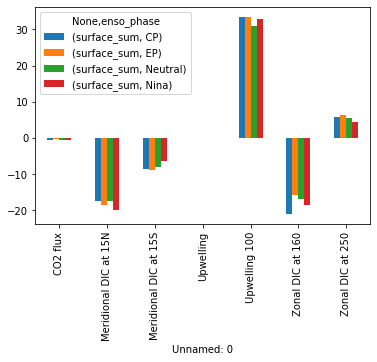

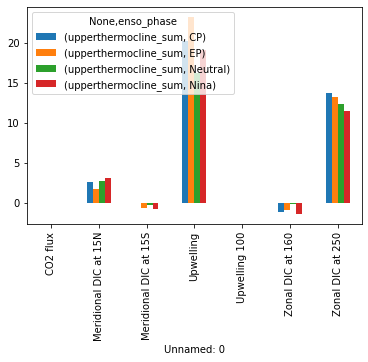

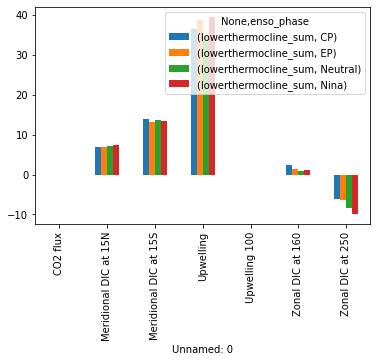

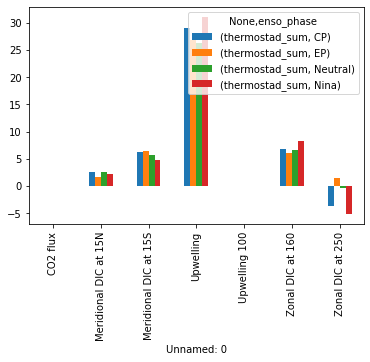

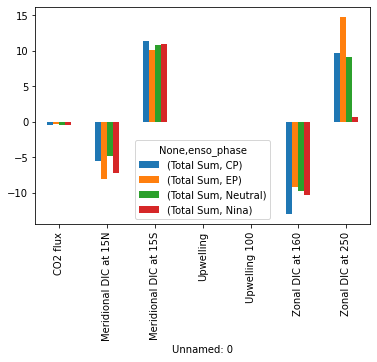

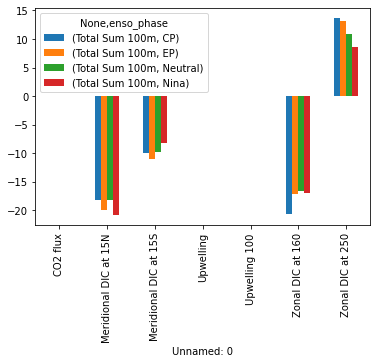

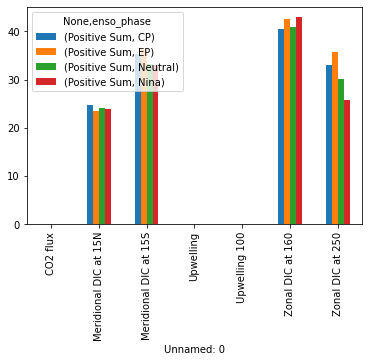

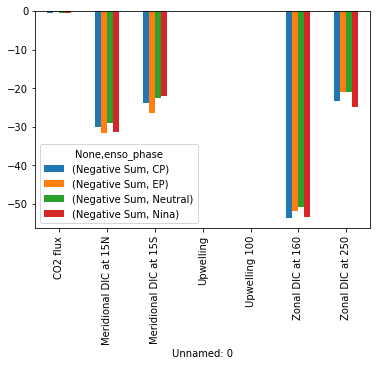

In [63]:
for col in new_tx.columns[:-1]:
    df=new_tx[[col,'enso_phase']]#.plot.bar()
    df.pivot(columns='enso_phase').plot.bar()#plt.show()

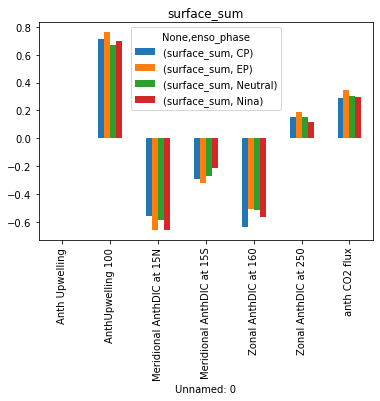

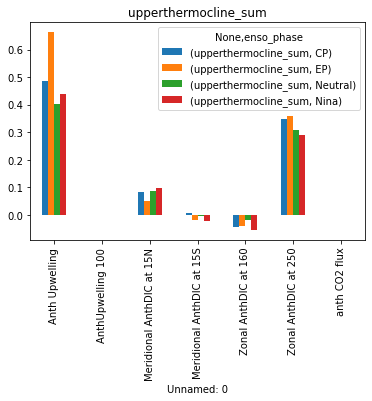

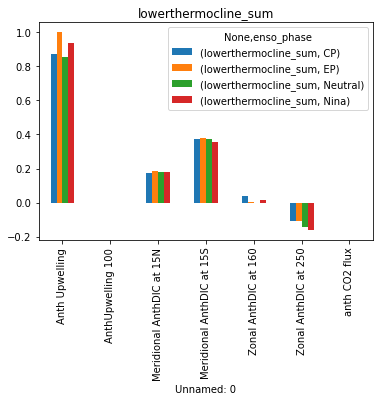

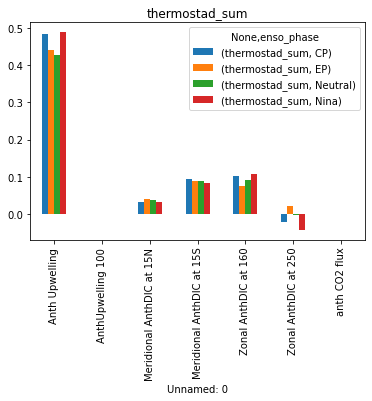

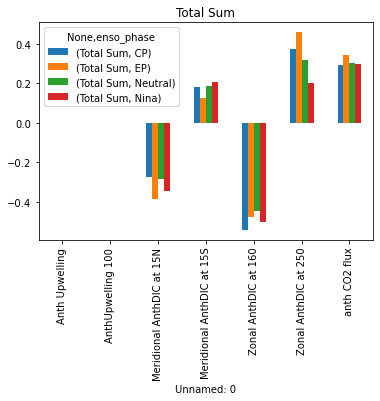

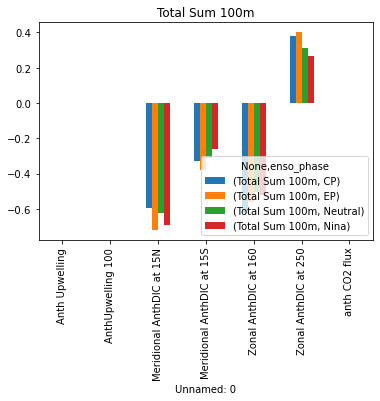

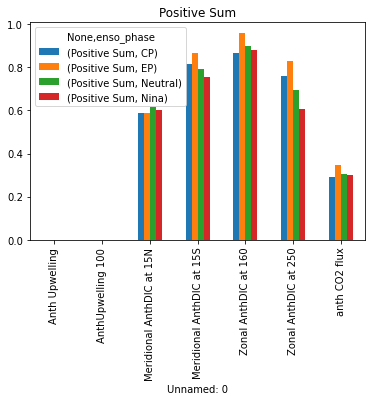

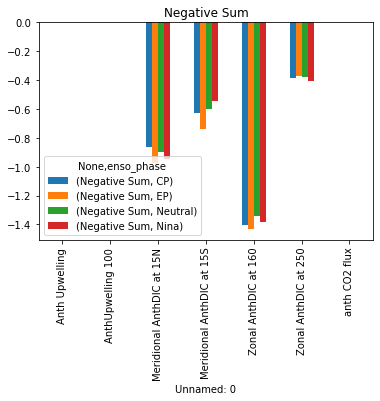

In [64]:
for col in new_tx_anth.columns[:-1]:
    df=new_tx_anth[[col,'enso_phase']]#.plot.bar()
    df.pivot(columns='enso_phase').plot.bar()#plt.show()
    plt.title(col)

In [51]:
new_tx_anth.index.str.split(' ').str[0]#.groupby('surface_sum')

Index(['Anth', 'AnthUpwelling', 'Meridional', 'Meridional', 'Zonal', 'Zonal',
       'anth', 'Anth', 'AnthUpwelling', 'Meridional', 'Meridional', 'Zonal',
       'Zonal', 'anth', 'Anth', 'AnthUpwelling', 'Meridional', 'Meridional',
       'Zonal', 'Zonal', 'anth', 'Anth', 'AnthUpwelling', 'Meridional',
       'Meridional', 'Zonal', 'Zonal', 'anth'],
      dtype='object', name='Unnamed: 0')

In [52]:
new_tx.index.str.split(' ').str[2]#.groupby('surface_sum')

Index([ nan, 'at', 'at',  nan,  nan, 'at', 'at',  nan, 'at', 'at',  nan,  nan,
       'at', 'at',  nan, 'at', 'at',  nan,  nan, 'at', 'at',  nan, 'at', 'at',
        nan,  nan, 'at', 'at'],
      dtype='object', name='Unnamed: 0')

In [53]:
new_tx.index.str.split(' ').str[3]#.groupby('surface_sum')


Index([  nan,  '3N',  '3S',   nan,   nan, '160', '250',   nan,  '3N',  '3S',
         nan,   nan, '160', '250',   nan,  '3N',  '3S',   nan,   nan, '160',
       '250',   nan,  '3N',  '3S',   nan,   nan, '160', '250'],
      dtype='object', name='Unnamed: 0')

In [54]:
df=new_tx[[col,'enso_phase']]#set_index(['Unnamed: 0'])#.stack()

In [55]:
#.groupby('enso_phase')[col].apply(list)
#df#.apply(pd.Series)

In [56]:
grouper = df.groupby('enso_phase')
df = pd.concat([pd.Series(v[col].tolist(), name=k) for k, v in grouper], axis=1)

In [57]:
new_tx#df

surface_sum  upperthermocline_sum  lowerthermocline_sum  \
Unnamed: 0                                                                      
CO2 flux                   -0.153                   NaN                   NaN   
Meridional DIC at 3N      -25.271                 7.241                 7.381   
Meridional DIC at 3S       -0.383                -7.334                11.763   
Upwelling                     NaN                35.374                46.773   
Upwelling 100              48.164                   NaN                   NaN   
Zonal DIC at 160          -13.835                 4.404                13.751   
Zonal DIC at 250            1.793                 3.927               -12.158   
CO2 flux                   -0.144                   NaN                   NaN   
Meridional DIC at 3N      -23.716                 6.603                 7.333   
Meridional DIC at 3S       -4.731                -3.468                 9.651   
Upwelling                     NaN                34.633                44.939   
Upwelling 100              44.767                   NaN                   NaN   
Zonal DIC at 160          -12.094                 4.238                11.866   
Zonal DIC at 250            2.221                 3.215               -12.026   
CO2 flux                   -0.161                   NaN                   NaN   
Meridional DIC at 3N      -20.657                 7.290                 7.499   
Meridional DIC at 3S       -1.358                -6.346                11.049   
Upwelling                     NaN                30.339                42.877   
Upwelling 100              43.815                   NaN                   NaN   
Zonal DIC at 160           -9.639                 5.068                12.891   
Zonal DIC at 250            1.386                 3.137               -14.135   
CO2 flux                   -0.153                   NaN                   NaN   
Meridional DIC at 3N      -21.102                 7.885                 7.527   
Meridional DIC at 3S        2.673                -7.486                11.789   
Upwelling                     NaN                32.597                43.799   
Upwelling 100              44.110                   NaN                   NaN   
Zonal DIC at 160           -8.129                 4.380                13.343   
Zonal DIC at 250            0.951                 3.107               -15.376   

                      thermostad_sum  Total Sum  Total Sum 100m  Positive Sum  \
Unnamed: 0                                                                      
CO2 flux                         NaN     -0.153             NaN           NaN   
Meridional DIC at 3N           2.909     -7.740         -25.426        33.256   
Meridional DIC at 3S           6.136     10.182         -21.206        43.115   
Upwelling                     26.309        NaN             NaN           NaN   
Upwelling 100                    NaN        NaN             NaN           NaN   
Zonal DIC at 160              10.892     15.211         -13.628        29.774   
Zonal DIC at 250              -4.740    -11.178          -1.370         6.008   
CO2 flux                         NaN     -0.144             NaN           NaN   
Meridional DIC at 3N           1.593     -8.187         -23.371        31.797   
Meridional DIC at 3S           5.430      6.881         -19.579        39.793   
Upwelling                     23.359        NaN             NaN           NaN   
Upwelling 100                    NaN        NaN             NaN           NaN   
Zonal DIC at 160               5.645      9.656         -11.975        23.352   
Zonal DIC at 250              -3.455    -10.044          -1.953         6.520   
CO2 flux                         NaN     -0.161             NaN           NaN   
Meridional DIC at 3N           0.410     -5.459         -20.409        30.726   
Meridional DIC at 3S           4.935      8.280         -21.992        42.311   
Upwelling                     21.916        NaN     

<AxesSubplot:xlabel='Unnamed: 0'>

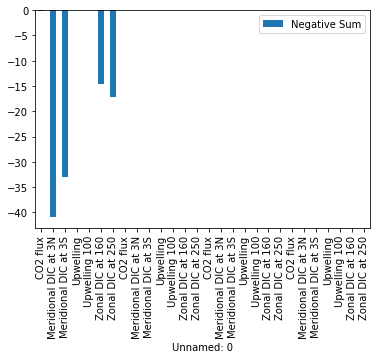

In [58]:
dat=new_tx[[col,'enso_phase']]
dat.where(dat['enso_phase']=='CP').plot.bar()

enso_phase
CP         AxesSubplot(0.125,0.125;0.775x0.755)
EP         AxesSubplot(0.125,0.125;0.775x0.755)
Neutral    AxesSubplot(0.125,0.125;0.775x0.755)
Nina       AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

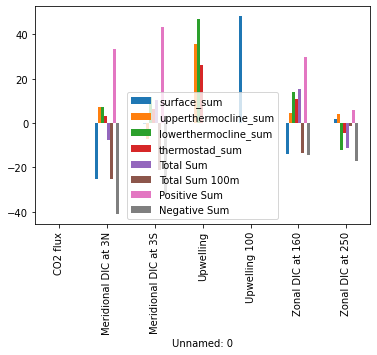

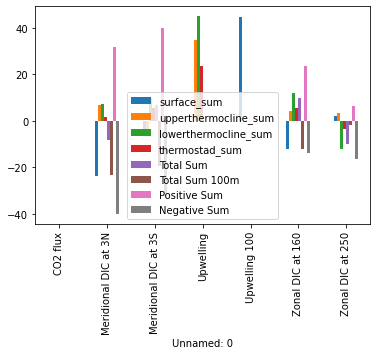

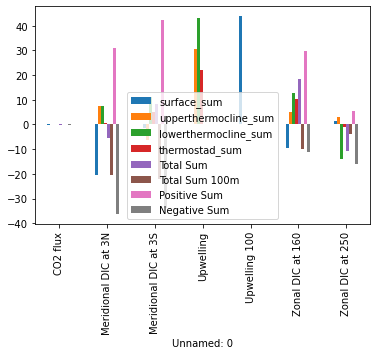

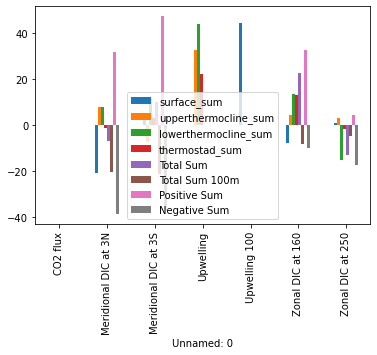

In [59]:
new_tx.groupby('enso_phase').plot.bar()

TypeError: bad operand type for abs(): 'str'

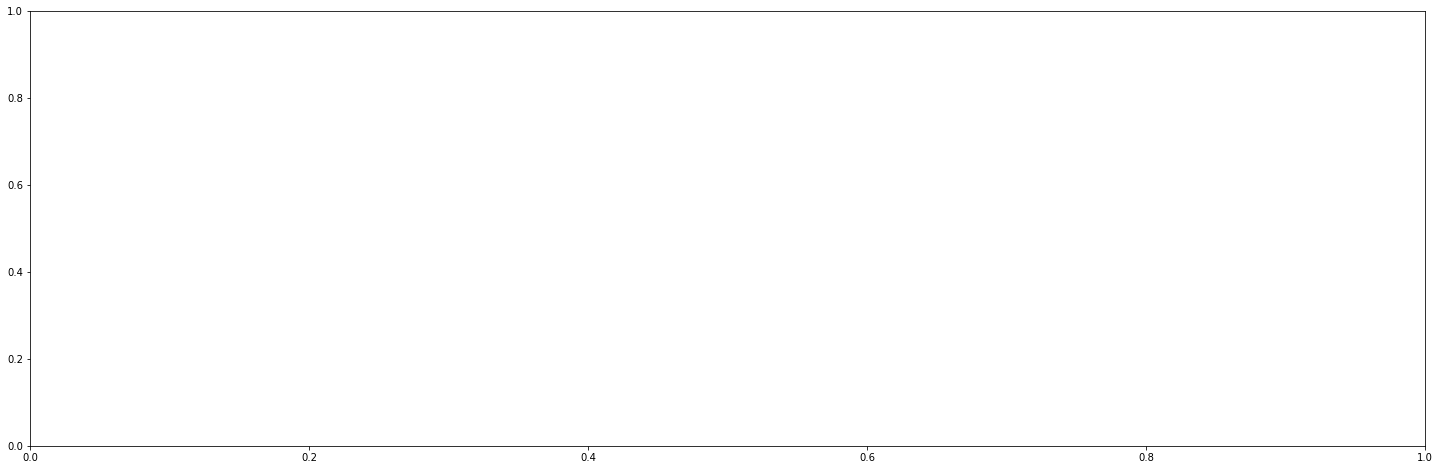

In [60]:
plt.figure(figsize=(25,8))
ax=plt.subplot(111)
abs(new_tx).round(3).plot.bar(ax=ax)
for container in ax.containers:
    ax.bar_label(container,rotation=90,label_type='edge',padding=4)
#plt.ylim([0,4])
plt.legend(fontsize=14)

In [ ]:
plt.figure(figsize=(25,8))
ax=plt.subplot(111)
abs(new_tx_anth).round(3).plot.bar(ax=ax)
for container in ax.containers:
    ax.bar_label(container,rotation=90,label_type='edge',padding=4)
plt.ylim([0,4])
plt.legend(fontsize=14)

In [ ]:
new_tx

In [ ]:
# SORT BY EACH FACE

face_data=[new_tx,new_tx_anth]

box_faces=['3s','3n','160','250','upwelling 500','upwelling 700','upwelling 100','flux']
box_faces=['3s','3n','160','250','upwelling 700','flux']


for i,df in enumerate(face_data):
    
    box_res=pd.DataFrame()
    for face in box_faces:
        result=df[df.index.str.lower().str.contains(face)]
        #print(result)
        result1=result.mean()
        result1.name=face
        #print(result.mean())
        box_res=box_res.append(result1)
        #print(result)
    if i==0:
        print('Total DIC transport')
    elif i==1:
        print('Anth DIC transport')
        
    plt.figure(figsize=(12,8))
    ax=plt.subplot(111)
    box_res.plot.bar(ax=ax)
    plt.axhline(0,c='k')
    plt.show()
    
    print(box_res)
    #plt.figure(figsize=(12,5))
    print(box_res.mean())
    box_res.mean().plot.bar()
    plt.axhline(0,c='k')
    plt.show()

In [ ]:
# SORT BY IN AND OUT
# Calculate Total In / Out transport
face_data=[new_tx,new_tx_anth]
box_faces=[' in',' out']
for a,df in enumerate(face_data):
    box_res=pd.DataFrame()
    for i,face in enumerate(box_faces):
        
        direction=df[df.index.str.lower().str.contains(face)]
        result2=direction.mean()
        result2.name=str(face[1:])
        box_res=box_res.append(result2)
        #print(direction)
    if a==0:
        print(f'Total DIC transport {face}')
    elif a==1:
        print(f'Anth DIC transport {face}')
    print(box_res)
    print(box_res.mean())
#        print(box_res.mean())

In [ ]:
# Richards Depth Grid Calculation

docn=phys
mdepth=docn.st_ocean.copy()
dbot=np.copy(docn.sw_ocean)
dthick=dbot*0
dthick[1:50]=dbot[1:50]-dbot[0:49]

dthick[0]=dbot[0]
print(dthick,dbot)
mdepth=mdepth*0+dthick
mdepth

In [ ]:
# Old Upwelling Estimates

plot=True
if plot==True:

    #anth DIC
    T_B_data_holder=[upwelling_100.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_100.sel(time=slice('2000-01-01','2020-01-01')),
                     upwelling_500.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_500.sel(time=slice('2000-01-01','2020-01-01')),
                     upwelling_700.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_700.sel(time=slice('2000-01-01','2020-01-01')),

                     flux.sel(time=slice('2000-01-01','2020-01-01'))*-1,
                     anthflux.sel(time=slice('2000-01-01','2020-01-01'))*-1]

    #T_B_names=['Upwelling','Anthropogenic Upwelling','Upwelling Old', 'Anth Upwelling Old', 'CO2 flux', 'anth CO2 flux', 'CO2 flux OLD',' anth CO2 flux OLD']
    T_B_names=['Upwelling 100','Anthropogenic Upwelling 100','Upwelling 500','Anthropogenic Upwelling 500','Upwelling 700','Anthropogenic Upwelling 700','CO2 flux', 'anth CO2 flux']


    for i, T_B_data in enumerate(T_B_data_holder):
        if i==0:
            levs=None#np.arange(-40,45,5)
        elif i==1:
            levs=None#np.arange(-2,2.2,0.2)
        
        
        else: levs=None
        plt.figure(figsize=(20,4))
        plt.subplot(141)
        lslice=slice(-3,3)
        upwelling_dat=T_B_data.sel(lat=lslice,lon=slice(150,270))

        upwelling_dat.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_neutral=xarray_posneg_calc(upwelling_dat,enso_months=neutral_events,run_density_calc=False)

        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        #print(asum)
        plt.title(f'Neutral {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(142)
        upwelling_dat.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_ep=xarray_posneg_calc(upwelling_dat,enso_months=ep_events,run_density_calc=False)
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        #print(asum)
        plt.title(f'EP {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(143)
        upwelling_dat.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_cp=xarray_posneg_calc(upwelling_dat,enso_months=cp_events,run_density_calc=False)
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        plt.title(f'CP {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(144)
        upwelling_dat.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_nina=xarray_posneg_calc(upwelling_dat,enso_months=nina_events,run_density_calc=False)
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        plt.title(f'Nina {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])


        plt.tight_layout()
        plt.show()
         
        temp_holder=pd.DataFrame({'Neutral':asum_neutral,'EP':asum_ep,'CP':asum_cp,'Nina':asum_nina},index=[f'{T_B_names[i]} in',f'{T_B_names[i]} out'])
        dic_transport_through_box=dic_transport_through_box.append(temp_holder)

In [ ]:
upwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').interp(st_ocean=cafe_wt.rename({'sw_ocean':'st_ocean'}).st_ocean).rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').interp(st_ocean=cafe_wt.rename({'sw_ocean':'st_ocean'}).st_ocean).rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups


upwelling=upwelling.interp(st_ocean=cafe_potential_density.st_ocean)
anthupwelling=anthupwelling.interp(st_ocean=cafe_potential_density.st_ocean)


surface_to_upperthermocline=upwelling.where((density_timefix.chunk('auto')>=1022.8)&(density_timefix.chunk('auto')<=1023.2)).mean(dim='st_ocean') #Average across a few pixels
upper_to_lowerthermocline=upwelling.where((density_timefix.chunk('auto')>=1024.3)&(density_timefix.chunk('auto')<=1024.7)).mean(dim='st_ocean')
lowerthermocline_to_thermostad=upwelling.where((density_timefix.chunk('auto')>=1026.1)&(density_timefix.chunk('auto')<=1026.5)).mean(dim='st_ocean')

anth_surface_to_upperthermocline=anthupwelling.where((density_timefix.chunk('auto')>=1022.8)&(density_timefix.chunk('auto')<=1023.2)).mean(dim='st_ocean') #Average across a few pixels
anth_upper_to_lowerthermocline=anthupwelling.where((density_timefix.chunk('auto')>=1024.3)&(density_timefix.chunk('auto')<=1024.7)).mean(dim='st_ocean')
anth_lowerthermocline_to_thermostad=anthupwelling.where((density_timefix.chunk('auto')>=1026.1)&(density_timefix.chunk('auto')<=1026.5)).mean(dim='st_ocean')


